#### By: Peyman Shahidi
#### Created: Oct 19, 2025
#### Last Edit: Oct 25, 2025

<br>

In [341]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [342]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index"

In [343]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [344]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [345]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [346]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


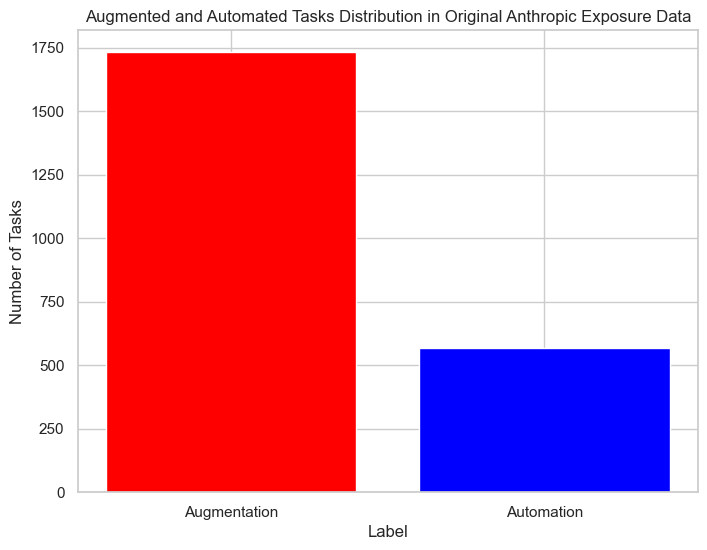

In [347]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [348]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [349]:
# # Reshuffle task assignments while preserving SOC hierarchy structure
# # Each occupation unit (O*NET-SOC Code + hierarchy levels) stays intact, but tasks are randomly reassigned
# # COMPLETELY UNRESTRICTED: Each task assigned to random occupation, no constraints on tasks per occupation

# # Create a copy of the data for reshuffling
# reshuffled_data = merged_data.copy()

# # Create SOC hierarchy levels with descriptive names from the O*NET-SOC Code
# reshuffled_data['soc_Major_Group_Code_Code_Code'] = reshuffled_data['O*NET-SOC Code'].str[:2]
# reshuffled_data['soc_minor_group'] = reshuffled_data['O*NET-SOC Code'].str[:5] 
# reshuffled_data['soc_broad_occupation'] = reshuffled_data['O*NET-SOC Code'].str[:8]
# reshuffled_data['soc_detailed_occupation'] = reshuffled_data['O*NET-SOC Code']

# # Get unique occupation units (with all hierarchy levels intact)
# occupation_units = reshuffled_data[['O*NET-SOC Code', 'Occupation Title', 'soc_major_group', 
#                                    'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']].drop_duplicates()

# print(f"Number of unique occupation units: {len(occupation_units):,}")

# # Get all unique tasks (each task appears only once)
# unique_tasks = reshuffled_data[['Task ID', 'Task Title', 'Task Type', 'gpt4_exposure', 
#                                'human_labels', 'task_normalized', 'task_name', 
#                                'automation', 'augmentation', 'label']].drop_duplicates()

# print(f"Number of unique tasks: {len(unique_tasks):,}")

# # Set random seed for reproducibility
# np.random.seed(42)

# # UNRESTRICTED ASSIGNMENT: Each task randomly assigned to any occupation unit
# # No constraints on how many tasks per occupation
# n_tasks = len(unique_tasks)
# n_occupations = len(occupation_units)

# # Random assignment: each task gets assigned to a completely random occupation
# random_occupation_indices = np.random.choice(n_occupations, size=n_tasks, replace=True)

# print(f"Assigning {n_tasks:,} tasks randomly across {n_occupations:,} occupation units")

# # Create the reshuffled dataset
# reshuffled_list = []

# for task_idx in range(n_tasks):
#     occ_idx = random_occupation_indices[task_idx]
    
#     # Get task information
#     task_row = unique_tasks.iloc[task_idx].to_dict()
    
#     # Get occupation information  
#     occ_row = occupation_units.iloc[occ_idx].to_dict()
    
#     # Combine them
#     combined_row = {**task_row, **occ_row}
#     reshuffled_list.append(combined_row)

# # Create the reshuffled DataFrame
# reshuffled_data = pd.DataFrame(reshuffled_list)

# print(f"Reshuffled dataset created with {len(reshuffled_data):,} rows")

# # Verify the reshuffling worked correctly
# print(f"\nOriginal dataset task distribution by occupation:")
# original_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {original_task_counts.min()}")
# print(f"Max tasks per occupation: {original_task_counts.max()}")
# print(f"Mean tasks per occupation: {original_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {original_task_counts.std():.2f}")

# print(f"\nReshuffled dataset task distribution by occupation:")
# reshuffled_task_counts = reshuffled_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {reshuffled_task_counts.min()}")
# print(f"Max tasks per occupation: {reshuffled_task_counts.max()}")
# print(f"Mean tasks per occupation: {reshuffled_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {reshuffled_task_counts.std():.2f}")

# # Count occupations with zero tasks
# zero_task_occupations = (reshuffled_task_counts == 0).sum()
# print(f"Occupations with zero tasks: {zero_task_occupations}")

# print(f"\nVerification:")
# print(f"Number of unique occupations preserved: {reshuffled_data['O*NET-SOC Code'].nunique() == merged_data['O*NET-SOC Code'].nunique()}")
# print(f"Number of unique tasks preserved: {reshuffled_data['Task ID'].nunique() == unique_tasks['Task ID'].nunique()}")
# print(f"Each task appears exactly once: {len(reshuffled_data) == len(unique_tasks)}")

# # Show SOC hierarchy column names
# print(f"\nSOC hierarchy columns created:")
# soc_columns = ['soc_major_group', 'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']
# for col in soc_columns:
#     print(f"  {col}: {reshuffled_data[col].nunique():,} unique values")


# # Set reshuffled data as the final dataset
# merged_data = reshuffled_data.copy()

# # Show sample of reshuffled data
# print(f"\nSample of reshuffled data:")
# reshuffled_data.head()

In [350]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [351]:
# # Only keep data for high AI-exposure major groups
# high_ai_exposure_major_groups = ['13-0000', '15-0000', '19-0000', '21-0000', '23-0000', '25-0000', '27-0000', '41-0000', '43-0000']
# merged_data = merged_data[merged_data['Major_Group_Code'].isin(high_ai_exposure_major_groups)].reset_index(drop=True)

### Check if my naive classification of Eloundou et al. (2024)'s Task AI-ability is consistent with the Anthropic Data

Takeaway --> My Naive Classification is not good

In [352]:
# Plot histograms of gpt4_exposure and human_labels within Automation and Augmentation groups
# Filter out rows with missing labels (unmatched tasks)
matched_data = merged_data[merged_data['label'].notna()].copy()

print(f"Number of matched tasks: {len(matched_data):,}")
print(f"Distribution of labels in matched data:")
print(matched_data['label'].value_counts())

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each group
colors = {'Automation': 'red', 'Augmentation': 'blue'}

# Collect all y-values to determine global y-axis scale
all_y_values = []

# Top row: gpt4_exposure distributions
if 'gpt4_exposure' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        subset = matched_data[matched_data['label'] == label]
        if len(subset) > 0:
            gpt4_counts = subset['gpt4_exposure'].value_counts().sort_index()
            all_y_values.extend(gpt4_counts.values)

# Bottom row: human_labels distributions  
if 'human_labels' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        subset = matched_data[matched_data['label'] == label]
        if len(subset) > 0:
            human_counts = subset['human_labels'].value_counts().sort_index()
            all_y_values.extend(human_counts.values)

# Calculate global y-axis limits with some padding
if all_y_values:
    max_y = max(all_y_values)
    y_limit = max_y * 1.1  # Add 10% padding
else:
    y_limit = 100  # Default fallback

# Top row: gpt4_exposure distributions
if 'gpt4_exposure' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        ax = axes[0, i]
        subset = matched_data[matched_data['label'] == label]
        
        if len(subset) > 0:
            gpt4_counts = subset['gpt4_exposure'].value_counts().sort_index()
            bars = ax.bar(gpt4_counts.index, gpt4_counts.values, color=colors[label], alpha=0.7)
            # Annotate bars with raw counts and percentage of this subset
            for bar, count in zip(bars, gpt4_counts.values):
                height = bar.get_height()
                pct = count / len(subset) * 100 if len(subset) > 0 else 0
                ax.text(bar.get_x() + bar.get_width() / 2, height + y_limit * 0.01, f"{int(count):,}\n({pct:.1f}%)", ha='center', va='bottom', fontsize=8, fontweight='bold')
            ax.set_title(f'GPT-4 Exposure Distribution - {label} Tasks\n(n={len(subset):,})')
            ax.set_xlabel('GPT-4 Exposure Level')
            ax.set_ylabel('Number of Tasks')
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, y_limit)
        else:
            ax.text(0.5, 0.5, f'No {label} tasks found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'GPT-4 Exposure - {label} (No Data)')
else:
    for i in range(2):
        axes[0, i].text(0.5, 0.5, 'gpt4_exposure column not found', ha='center', va='center', transform=axes[0, i].transAxes)
        axes[0, i].set_title('GPT-4 Exposure - Column Not Found')

# Bottom row: human_labels distributions
if 'human_labels' in matched_data.columns:
    for i, label in enumerate(['Automation', 'Augmentation']):
        ax = axes[1, i]
        subset = matched_data[matched_data['label'] == label]
        
        if len(subset) > 0:
            human_counts = subset['human_labels'].value_counts().sort_index()
            bars = ax.bar(human_counts.index, human_counts.values, color=colors[label], alpha=0.7)
            # Annotate bars with raw counts and percentage of this subset
            for bar, count in zip(bars, human_counts.values):
                height = bar.get_height()
                pct = count / len(subset) * 100 if len(subset) > 0 else 0
                ax.text(bar.get_x() + bar.get_width() / 2, height + y_limit * 0.01, f"{int(count):,}\n({pct:.1f}%)", ha='center', va='bottom', fontsize=8, fontweight='bold')
            ax.set_title(f'Human Labels Distribution - {label} Tasks\n(n={len(subset):,})')
            ax.set_xlabel('Human Label Level')
            ax.set_ylabel('Number of Tasks')
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, y_limit)
        else:
            ax.text(0.5, 0.5, f'No {label} tasks found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Human Labels - {label} (No Data)')
else:
    for i in range(2):
        axes[1, i].text(0.5, 0.5, 'human_labels column not found', ha='center', va='center', transform=axes[1, i].transAxes)
        axes[1, i].set_title('Human Labels - Column Not Found')

plt.suptitle('(Inconsistency of My Naive AI-ability Classification of Eloundou et al. (2024)\' measure against Anthropic\'s Measure)\n\n' \
'               Distribution of Eloundou et al. (2024) AI-ability Measure within Anthropic AI-ability Measures', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{output_plot_path}/falsification_of_my_naiveClassification.png', dpi=300, bbox_inches='tight')
plt.close()

Number of matched tasks: 12,546
Distribution of labels in matched data:
label
Manual          11005
Augmentation     1136
Automation        405
Name: count, dtype: int64


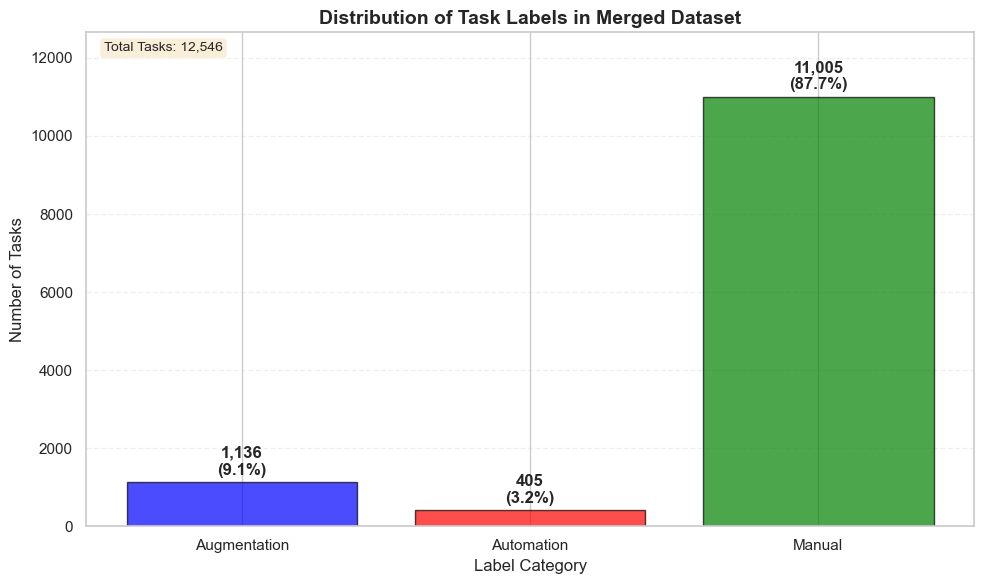

Detailed Label Distribution:
Automation  :     405 tasks (  3.2%)
Augmentation:   1,136 tasks (  9.1%)
Manual      :  11,005 tasks ( 87.7%)
Total       :  12,546 tasks (100.0%)


In [353]:
# Plot histogram of all three label values in a single histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get the distribution of all label values
label_counts = merged_data['label'].value_counts().sort_index()

# Define colors for each category
colors = {'Automation': 'red', 'Augmentation': 'blue', 'Manual': 'green'}

# Create the bar plot
bars = ax.bar(label_counts.index, label_counts.values, 
              color=[colors[label] for label in label_counts.index], 
              alpha=0.7, edgecolor='black', linewidth=1)

# Add value labels on top of each bar
for i, (label, count) in enumerate(label_counts.items()):
    percentage = (count / len(merged_data)) * 100
    ax.text(i, count + max(label_counts.values) * 0.01, 
            f'{count:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

# Customize the plot
ax.set_title('Distribution of Task Labels in Merged Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Label Category', fontsize=12)
ax.set_ylabel('Number of Tasks', fontsize=12)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Set y-axis limit with some padding
ax.set_ylim(0, max(label_counts.values) * 1.15)

# Add total count in the plot
total_tasks = len(merged_data)
ax.text(0.02, 0.98, f'Total Tasks: {total_tasks:,}', 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{output_plot_path}/all_labels_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("Detailed Label Distribution:")
print("=" * 40)
for label in ['Automation', 'Augmentation', 'Manual']:
    count = label_counts.get(label, 0)
    percentage = (count / total_tasks) * 100
    print(f"{label:12}: {count:7,} tasks ({percentage:5.1f}%)")
print("=" * 40)
print(f"{'Total':12}: {total_tasks:7,} tasks (100.0%)")

In [354]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']):
    num_tasks = group['Task ID'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    occupation_stats.append({
        'O*NET-SOC Code': soc_code,
        'Occupation Title': occ_title,
        'num_tasks': num_tasks,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/anthropic_occupationLevel_taskExposure_dataset.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head(5)

Number of occupations: 837
Range of tasks per occupation: 1 - 38

Sample of occupation analysis:


,O*NET-SOC Code,Occupation Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
0,11-1011.00,Chief Executives,19,0.68,0.32,0.32,0.00
1,11-1011.03,Chief Sustainability Officers,18,0.72,0.28,0.28,0.00
2,11-1021.00,General and Operations Managers,9,0.89,0.11,0.11,0.00
3,11-2011.00,Advertising and Promotions Managers,13,0.85,0.15,0.15,0.00
4,11-2021.00,Marketing Managers,12,0.67,0.33,0.33,0.00


In [355]:
# Create Minor_Group_Code-level analysis
# Group by Minor_Group_Code and calculate label fractions and task counts
minor_group_stats = []

for (mg_code, mg_title), group in merged_data.groupby(['Minor_Group_Code', 'Minor_Group_Title']):
    num_tasks = group['Task ID'].nunique()
    num_occs = group['O*NET-SOC Code'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    minor_group_stats.append({
        'Minor_Group_Code': mg_code,
        'Occupation Title': mg_title,
        'num_tasks': num_tasks,
        'num_occupations': num_occs,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

minor_group_analysis = pd.DataFrame(minor_group_stats)

# save occupation analysis to CSV
minor_group_analysis.to_csv(f'{output_data_path}/anthropic_minorGroupLevel_taskExposure_dataset.csv', index=False)

print(f"Number of Minor Groups: {len(minor_group_analysis):,}")
print(f"Range of tasks per Minor Group: {minor_group_analysis['num_tasks'].min()} - {minor_group_analysis['num_tasks'].max()}")
print(f"\nSample of Minor Group analysis:")
minor_group_analysis.head(5)

Number of Minor Groups: 94
Range of tasks per Minor Group: 15 - 420

Sample of Minor Group analysis:


,Minor_Group_Code,Occupation Title,num_tasks,num_occupations,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
0,11-1000,Top Executives,46,3,0.74,0.26,0.26,0.00
1,11-2000,"Advertising, Marketing, Promotions, Public Rel...",38,3,0.76,0.24,0.24,0.00
2,11-3000,Operations Specialties Managers,220,14,0.90,0.10,0.06,0.03
3,11-9000,Other Management Occupations,170,10,0.89,0.11,0.09,0.02
4,13-1000,Business Operations Specialists,302,20,0.86,0.14,0.09,0.04


## Relationship btwn # Tasks in Occupation vs. Share of Manual/Augmented/Automation Tasks At Different SOC Hierarchy Levels

- **Major Group**: 2-digit SOC codes (e.g., 11 = Management Occupations)
- **Minor Group**: 4-digit SOC codes (e.g., 11-10 = Top Executives) 
- **Broad Occupation**: 6-digit SOC codes (e.g., 11-1011 = Chief Executives)
- **Detailed Occupation**: Full SOC codes (e.g., 11-1011.00 = Chief Executives)

In [356]:
# Create SOC hierarchy levels from the O*NET-SOC Code
merged_data['major_group'] = merged_data['O*NET-SOC Code'].str[:2]
merged_data['minor_group'] = merged_data['O*NET-SOC Code'].str[:5] 
merged_data['broad_occupation'] = merged_data['O*NET-SOC Code'].str[:8]
merged_data['detailed_occupation'] = merged_data['O*NET-SOC Code']

# Function to analyze any grouping level
def analyze_grouping_level(data, group_col, level_name):
    """
    Analyze task fractions and counts at any grouping level
    """
    group_stats = []
    
    for group_code, group_data in data.groupby(group_col):
        num_tasks = group_data['Task ID'].nunique()
        total_tasks = len(group_data)
        
        manual_fraction = (group_data['label'] == 'Manual').sum() / total_tasks
        augmentation_fraction = (group_data['label'] == 'Augmentation').sum() / total_tasks  
        automation_fraction = (group_data['label'] == 'Automation').sum() / total_tasks
        # AI fraction is the sum of augmentation and automation fractions
        ai_fraction = augmentation_fraction + automation_fraction
        
        group_stats.append({
            'group_code': group_code,
            'level_name': level_name,
            'num_tasks': num_tasks,
            'manual_fraction': manual_fraction,
            'augmentation_fraction': augmentation_fraction,
            'automation_fraction': automation_fraction,
            'ai_fraction': ai_fraction
        })
    
    return pd.DataFrame(group_stats)

# Analyze all levels
soc_levels = [
    ('major_group', 'Major Group'),
    ('minor_group', 'Minor Group'), 
    ('broad_occupation', 'Broad Occupation'),
    ('detailed_occupation', 'Detailed Occupation')
]

all_analyses = []
for col, name in soc_levels:
    analysis = analyze_grouping_level(merged_data, col, name)
    all_analyses.append(analysis)
    print(f"{name}: {len(analysis)} groups, {analysis['num_tasks'].min()}-{analysis['num_tasks'].max()} tasks per group")

# Combine all analyses
combined_analysis = pd.concat(all_analyses, ignore_index=True)
print(f"\nTotal analysis records: {len(combined_analysis)}")
combined_analysis.head(10)

Major Group: 22 groups, 85-1332 tasks per group
Minor Group: 108 groups, 7-426 tasks per group
Broad Occupation: 723 groups, 1-130 tasks per group
Detailed Occupation: 837 groups, 1-38 tasks per group

Total analysis records: 1690
Detailed Occupation: 837 groups, 1-38 tasks per group

Total analysis records: 1690


,group_code,level_name,num_tasks,manual_fraction,augmentation_fraction,automation_fraction,ai_fraction
0,11,Major Group,843,0.88,0.10,0.02,0.12
1,13,Major Group,675,0.80,0.15,0.06,0.20
2,15,Major Group,547,0.62,0.32,0.07,0.38
3,17,Major Group,903,0.88,0.09,0.03,0.12
4,19,Major Group,869,0.79,0.17,0.04,0.21
5,21,Major Group,214,0.82,0.15,0.03,0.18
6,23,Major Group,85,0.73,0.19,0.08,0.27
7,25,Major Group,543,0.72,0.11,0.17,0.28
8,27,Major Group,517,0.81,0.12,0.07,0.19
9,29,Major Group,1332,0.89,0.10,0.01,0.11


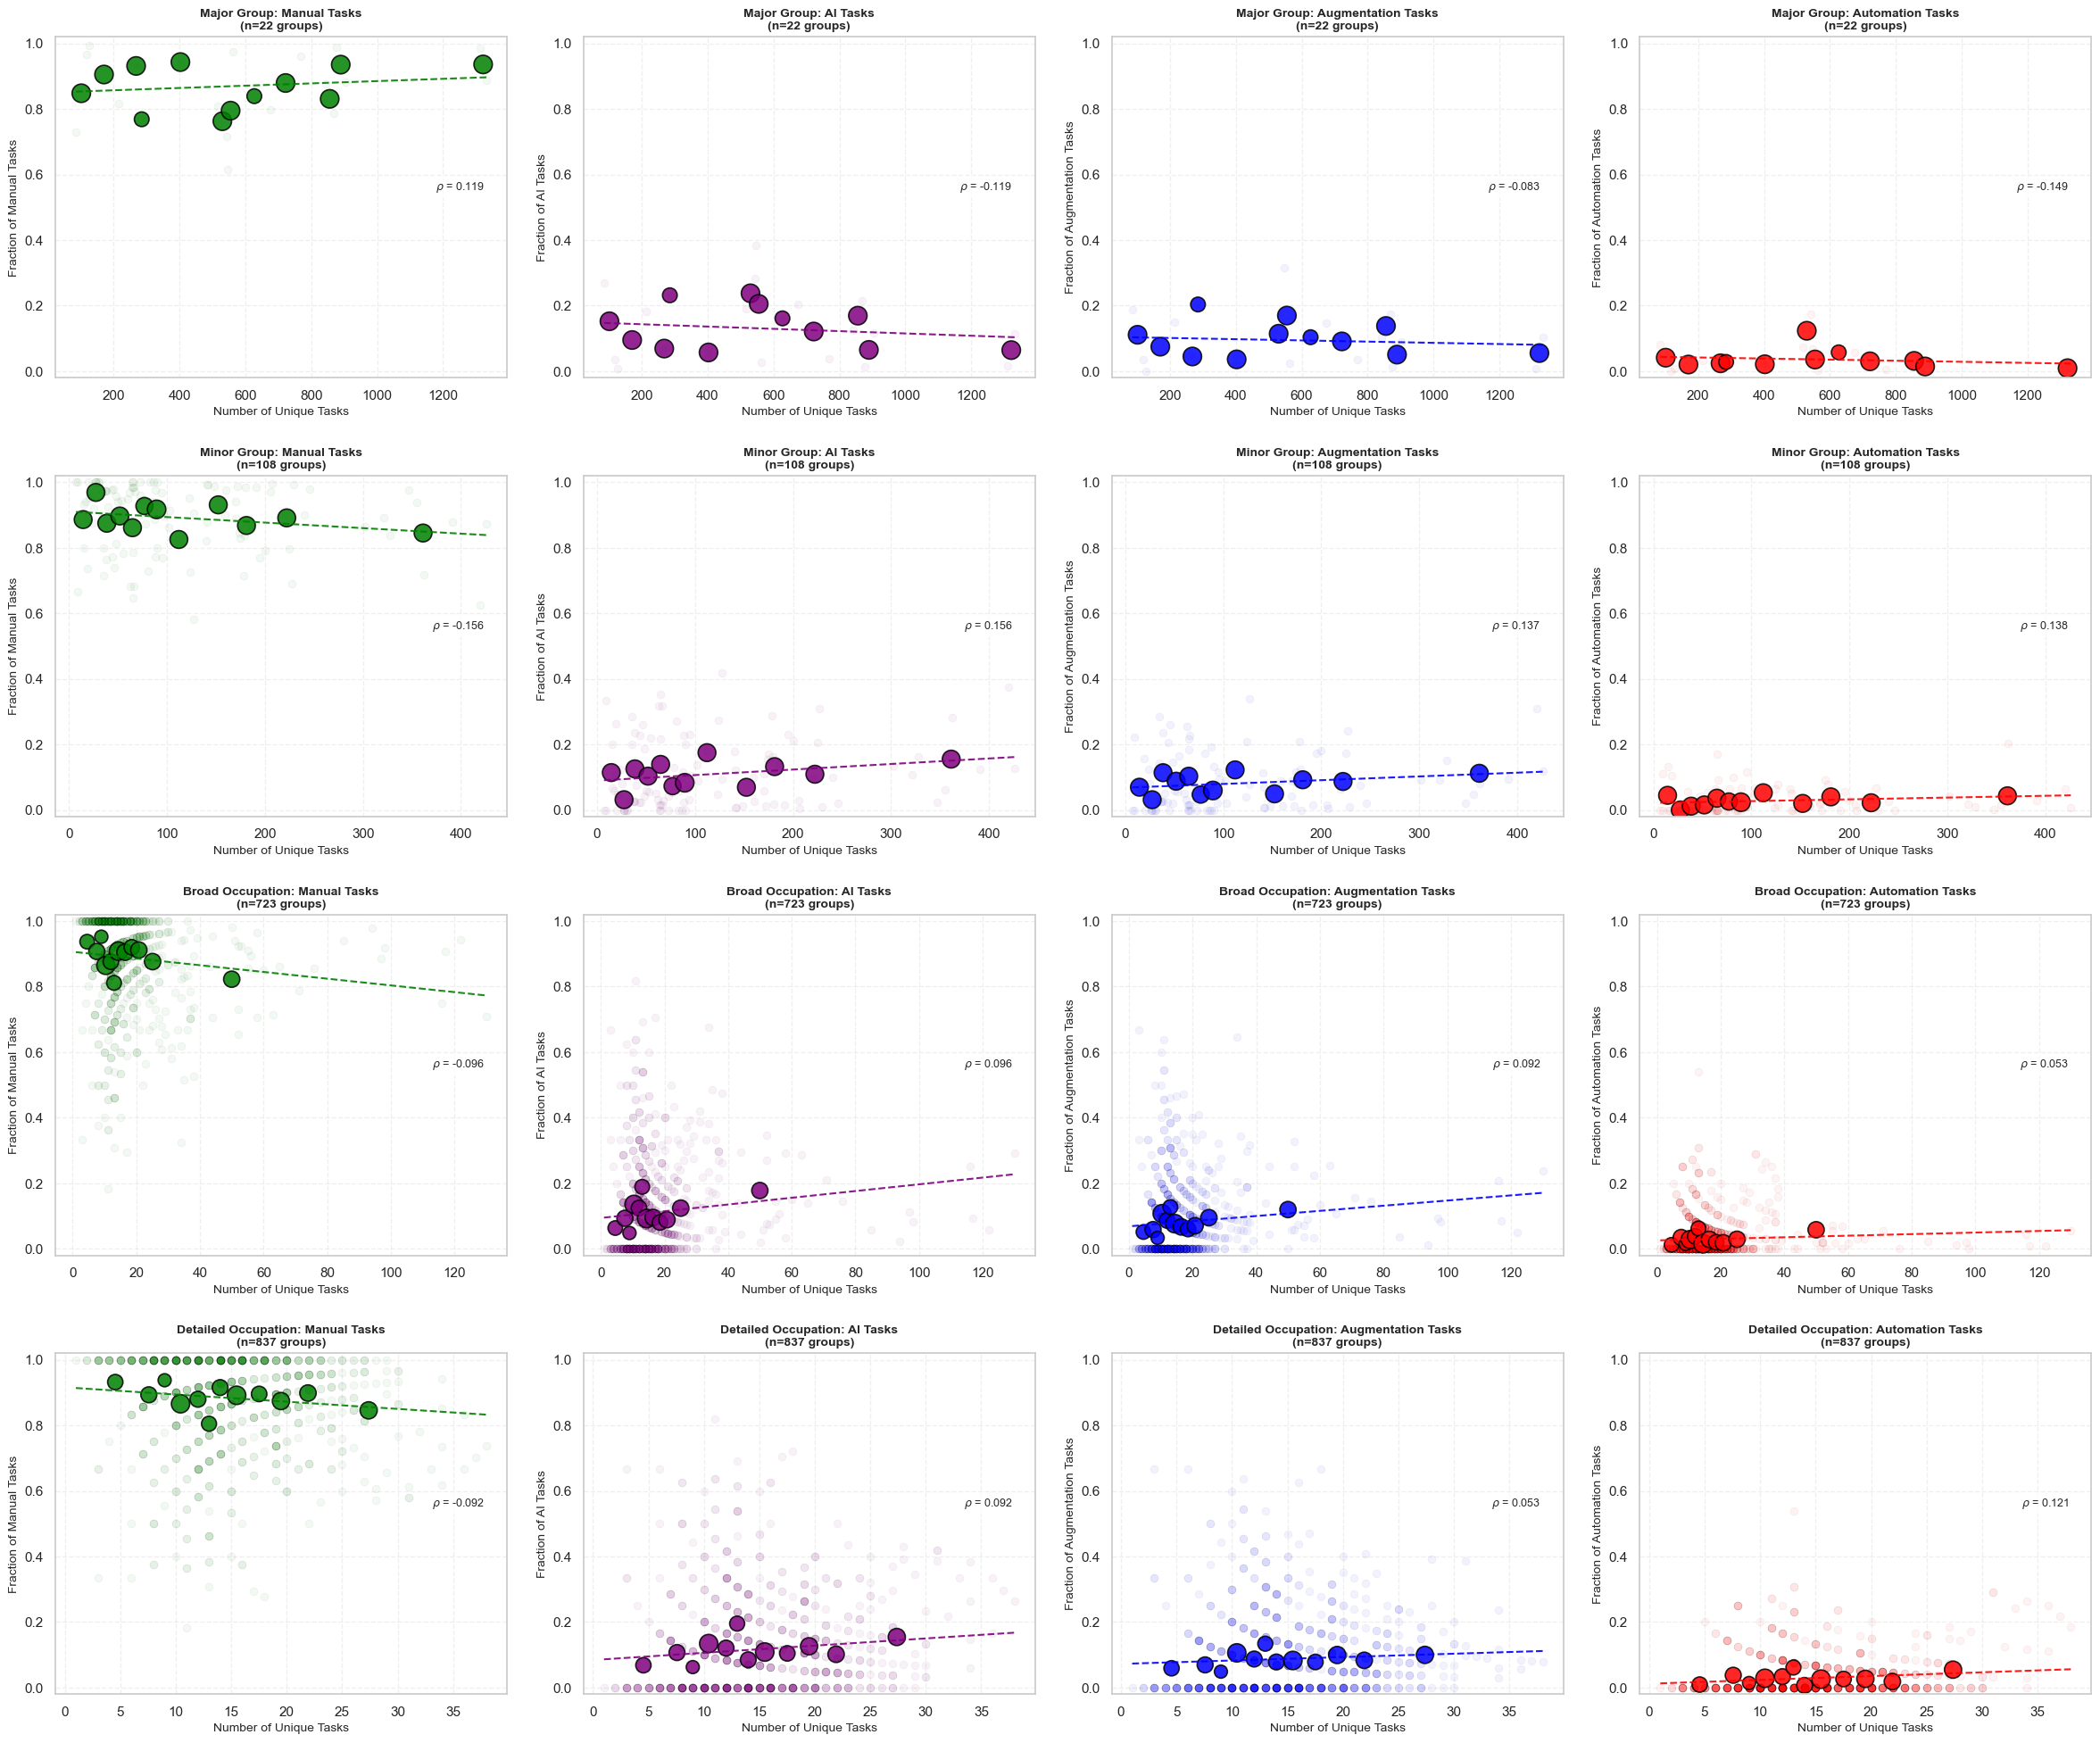

In [357]:
# Create a 4x4 figure showing scatter plots for all SOC levels with bin means (bins on x = num_tasks)
fig, axes = plt.subplots(4, 4, figsize=(24, 20))

# Define colors and labels for each plot (insert AI between Manual and Augmentation)
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

# Bins for num_tasks axis (x) - use quantile bins for proportional bin sizes
num_bins = 12

# Plot for each SOC level
for row, (col, level_name) in enumerate(soc_levels):
    # Get data for this level
    level_data = all_analyses[row]
    if len(level_data) == 0:
        continue

    # Use quantile-based bin edges so each bin has roughly equal observations
    x = level_data['num_tasks'].values
    x_min, x_max = x.min(), x.max()
    bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
    
    # Create scatter plots for each task type
    for col_idx, (fraction_col, label, color) in enumerate(plot_configs):
        ax = axes[row, col_idx]
        x = level_data['num_tasks'].values
        y = level_data[fraction_col].values
        
        # Scatter plot
        scatter = ax.scatter(x, y, alpha=0.05, color=color, s=40, edgecolors='black', linewidth=0.5)
        
        # Add fitted regression line (global only)
        if len(x) > 1 and np.std(x) > 0:
            coeffs = np.polyfit(x, y, 1)
            fit_fn = np.poly1d(coeffs)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = fit_fn(x_fit)
            ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)
        
        # Bin the x axis and overlay bin means (no bin-fitted line)
        bin_indices = np.digitize(x, bin_edges, right=True) - 1
        bin_means_x = []
        bin_means_y = []
        bin_counts = []
        for b in range(len(bin_edges) - 1):
            in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
            if b == len(bin_edges) - 2:
                # Include right edge in last bin
                in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
            if np.any(in_bin):
                bin_means_x.append(x[in_bin].mean())
                bin_means_y.append(y[in_bin].mean())
                bin_counts.append(in_bin.sum())
        
        # Scale marker sizes by bin counts
        min_size = 60
        max_size = 220
        sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []
        
        if bin_means_x:
            ax.scatter(bin_means_x, bin_means_y, color=color, s=sizes, alpha=0.85, edgecolors='black', linewidth=1.2)
        
        # Customize each subplot
        ax.set_xlabel('Number of Unique Tasks', fontsize=10)
        ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=10)
        ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} groups)', fontsize=10, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(-0.02, 1.02)
        x_padding = max(1, (x_max - x_min) * 0.05)
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        correlation = level_data[fraction_col].corr(level_data['num_tasks'])
        ax.text(0.95, 0.58, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout(pad=2.0)
plt.savefig(f'{output_plot_path}/SOChierarchy_numTasks_vs_taskTypes.png', dpi=300, bbox_inches='tight')
plt.show()

Observations used in regression: 837

Fitting model: no_FE | formula: ai_fraction ~ num_tasks

Fitting model: major_group_FE | formula: ai_fraction ~ num_tasks + C(major_group)

Fitting model: minor_group_FE | formula: ai_fraction ~ num_tasks + C(minor_group)


,model,coef_num_tasks,coef_4sig,se,pval,nobs
0,no_FE,0.00,0.002197,0.00,0.00,837
1,major_group_FE,-0.00,-0.001134,0.00,0.12,837
2,minor_group_FE,-0.00,-0.001787,0.00,0.03,837



Model: no_FE
                            OLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.895
Date:                Sat, 25 Oct 2025   Prob (F-statistic):            0.00507
Time:                        19:46:13   Log-Likelihood:                 399.47
No. Observations:                 837   AIC:                            -794.9
Df Residuals:                     835   BIC:                            -785.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0840      0.014      

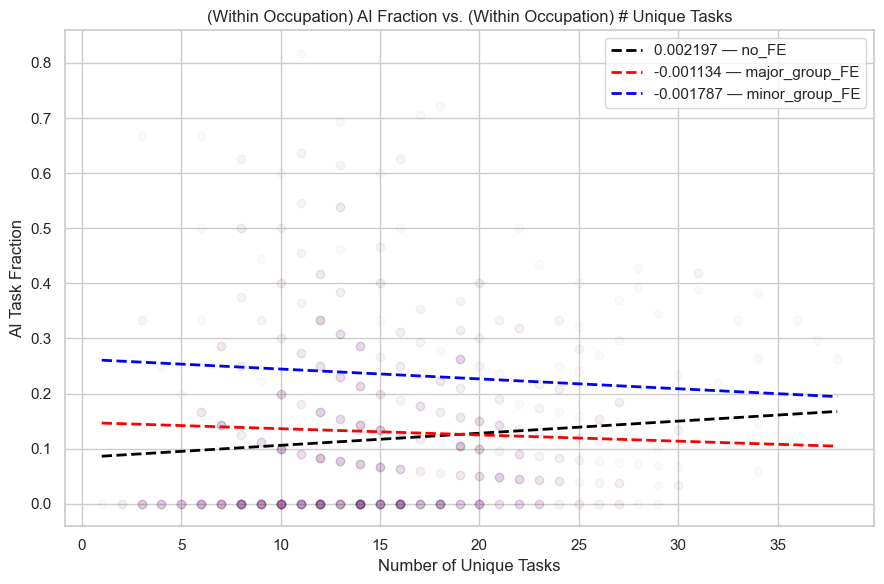

In [358]:
# Regression: AI task fraction on number of unique tasks (no FE, major_group FE, minor_group FE run in a loop)
import statsmodels.formula.api as smf
import seaborn as sns
sns.set(style='whitegrid')

# Prepare dataframe
df = occupation_analysis.copy()
df['major_group'] = df['O*NET-SOC Code'].astype(str).str[:2]
df['minor_group'] = df['O*NET-SOC Code'].astype(str).str[:5]
df = df.dropna(subset=['ai_fraction', 'num_tasks']).reset_index(drop=True)
print(f'Observations used in regression: {len(df):,}')

# Define FE options: None = no fixed effects, then major_group and minor_group
fe_options = [None, 'major_group', 'minor_group']
models = {}
results_summary = []

for fe in fe_options:
    if fe is None:
        formula = 'ai_fraction ~ num_tasks'
        label = 'no_FE'
    else:
        formula = f'ai_fraction ~ num_tasks + C({fe})'
        label = f'{fe}_FE'
    print(f'\nFitting model: {label} | formula: {formula}')
    model = smf.ols(formula, data=df).fit(cov_type='HC3')
    models[label] = model
    coef = model.params.get('num_tasks', np.nan)
    se = model.bse.get('num_tasks', np.nan)
    pval = model.pvalues.get('num_tasks', np.nan)
    # formatted coefficient with 4 significant digits (use 'nan' text for missing)
    formatted_coef = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    results_summary.append({'model': label, 'coef_num_tasks': coef, 'coef_4sig': formatted_coef, 'se': se, 'pval': pval, 'nobs': int(model.nobs)})

# Create and display a compact coefficient table for the num_tasks coefficient across models
coef_table = pd.DataFrame(results_summary)
display(coef_table)

# Print full summaries for each model
for label, model in models.items():
    print('\n' + '='*80)
    print(f'Model: {label}')
    print(model.summary())

# Compute quantile-binned means for overlay (will plot these with opacity=0.9)
num_bins = 8
x = df['num_tasks'].values
y = df['ai_fraction'].values
bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
bin_means_x = []
bin_means_y = []
bin_counts = []
for b in range(len(bin_edges) - 1):
    in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
    if b == len(bin_edges) - 2:
        in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
    if np.any(in_bin):
        bin_means_x.append(x[in_bin].mean())
        bin_means_y.append(y[in_bin].mean())
        bin_counts.append(in_bin.sum())
# sizes scaled by counts (guard against divide-by-zero)
if bin_counts:
    min_size = 80
    max_size = 300
    sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts]
else:
    sizes = []

# Plot fitted lines from each model on the same scatter for comparison and overlay binned scatters
fig, ax = plt.subplots(figsize=(9, 6))
# raw (faded) scatter of all observations
ax.scatter(df['num_tasks'], df['ai_fraction'], alpha=0.025, color='purple', edgecolors='k')
x_vals = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)

# # overlay binned scatter with high opacity (0.9)
# if bin_means_x:
#     ax.scatter(bin_means_x, bin_means_y, color='orange', s=sizes, alpha=0.9, edgecolors='black', linewidths=1.2, label='Binned means (alpha=0.9)')

# colors for each model label
colors = {'no_FE': 'black', 'major_group_FE': 'red', 'minor_group_FE': 'blue'}
for label, model in models.items():
    coef = model.params.get('num_tasks', np.nan)
    formatted = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    legend_label = f"{formatted} — {label}"
    if 'num_tasks' in model.params:
        intercept = model.params.get('Intercept', 0)
        slope = model.params.get('num_tasks', 0)
        ax.plot(x_vals, intercept + slope * x_vals, color=colors.get(label, 'gray'), linestyle='--', linewidth=2, label=legend_label)
ax.set_xlabel('Number of Unique Tasks')
ax.set_ylabel('AI Task Fraction')
ax.set_title('(Within Occupation) AI Fraction vs. (Within Occupation) # Unique Tasks')
ax.legend()
plt.tight_layout()
plt.savefig(f'{output_plot_path}/withinOcc_regression_aiTaskFraction_vs_numTasks.png', dpi=300, bbox_inches='tight')
plt.show()

### Repeat the same analysis as above but instead of counting tasks within occupation the unit of observation is minor group

Observations used in regression: 94

Fitting model: no_FE | formula: ai_fraction ~ num_tasks

Fitting model: major_group_FE | formula: ai_fraction ~ num_tasks + C(major_group)


,model,coef_num_tasks,coef_4sig,se,pval,nobs
0,no_FE,0.00,0.00022,0.00,0.17,94
1,major_group_FE,-0.00,-2.561e-05,0.00,0.82,94



Model: no_FE
                            OLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.900
Date:                Sat, 25 Oct 2025   Prob (F-statistic):              0.171
Time:                        19:46:14   Log-Likelihood:                 80.376
No. Observations:                  94   AIC:                            -156.8
Df Residuals:                      92   BIC:                            -151.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0846      0.019      

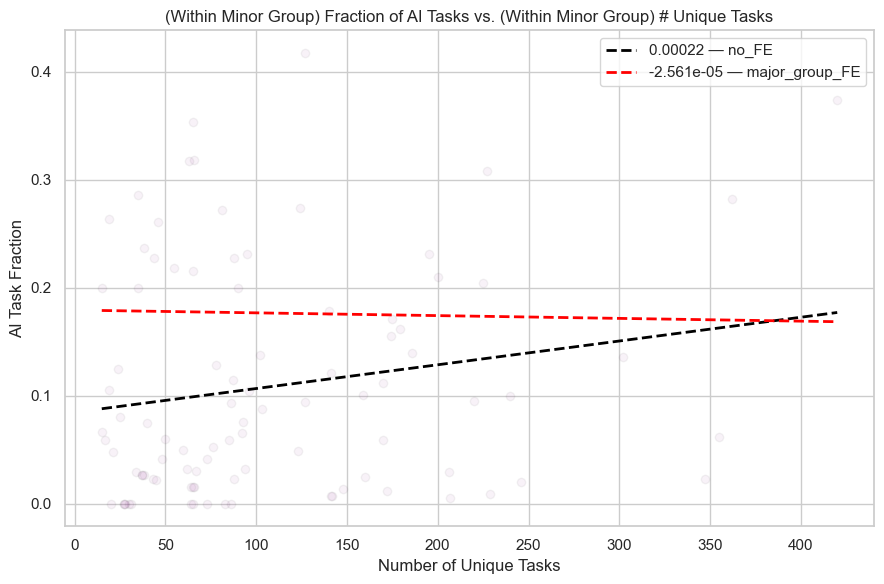

In [359]:
# Regression: AI task fraction on number of unique tasks (no FE, major_group FE)
import statsmodels.formula.api as smf
import seaborn as sns
sns.set(style='whitegrid')

# Prepare dataframe
df = minor_group_analysis.copy()
df['major_group'] = df['Minor_Group_Code'].astype(str).str[:2]
df = df.dropna(subset=['ai_fraction', 'num_tasks']).reset_index(drop=True)
print(f'Observations used in regression: {len(df):,}')

# Define FE options: None = no fixed effects, then major_group and minor_group
fe_options = [None, 'major_group']
models = {}
results_summary = []

for fe in fe_options:
    if fe is None:
        formula = 'ai_fraction ~ num_tasks'
        label = 'no_FE'
    else:
        formula = f'ai_fraction ~ num_tasks + C({fe})'
        label = f'{fe}_FE'
    print(f'\nFitting model: {label} | formula: {formula}')
    model = smf.ols(formula, data=df).fit(cov_type='HC3')
    models[label] = model
    coef = model.params.get('num_tasks', np.nan)
    se = model.bse.get('num_tasks', np.nan)
    pval = model.pvalues.get('num_tasks', np.nan)
    # formatted coefficient with 4 significant digits (use 'nan' text for missing)
    formatted_coef = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    results_summary.append({'model': label, 'coef_num_tasks': coef, 'coef_4sig': formatted_coef, 'se': se, 'pval': pval, 'nobs': int(model.nobs)})

# Create and display a compact coefficient table for the num_tasks coefficient across models
coef_table = pd.DataFrame(results_summary)
display(coef_table)

# Print full summaries for each model
for label, model in models.items():
    print('\n' + '='*80)
    print(f'Model: {label}')
    print(model.summary())

# Plot fitted lines from each model on the same scatter for comparison
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(df['num_tasks'], df['ai_fraction'], alpha=0.05, color='purple', edgecolors='k')
x_vals = np.linspace(df['num_tasks'].min(), df['num_tasks'].max(), 200)
# colors for each model label
colors = {'no_FE': 'black', 'major_group_FE': 'red'}
for label, model in models.items():
    coef = model.params.get('num_tasks', np.nan)
    formatted = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    legend_label = f"{formatted} — {label}"
    if 'num_tasks' in model.params:
        intercept = model.params.get('Intercept', 0)
        slope = model.params.get('num_tasks', 0)
        ax.plot(x_vals, intercept + slope * x_vals, color=colors.get(label, 'gray'), linestyle='--', linewidth=2, label=legend_label)
ax.set_xlabel('Number of Unique Tasks')
ax.set_ylabel('AI Task Fraction')
ax.set_title('(Within Minor Group) Fraction of AI Tasks vs. (Within Minor Group) # Unique Tasks')
ax.legend()
plt.tight_layout()
plt.savefig(f'{output_plot_path}/withinMinorGroup_regression_aiTaskFraction_vs_numTasks.png', dpi=300, bbox_inches='tight')
plt.show()


In [360]:
# Create separate figure sets highlighting each major group one at a time with bin means (bins on x=num_tasks)

# Run flag: set to True to generate all figures, False to skip heavy loop.
RUN_HIGHLIGHT_LOOP = True  # change to True when you want to generate all figures
TEST_HIGHLIGHT_MG = '11'    # a single major group to generate when RUN_HIGHLIGHT_LOOP is False

# Get unique major groups
unique_major_groups = sorted(merged_data['major_group'].unique())
print(f"Will create up to {len(unique_major_groups)} separate figure sets (save-only).")

# Map major group codes to readable names (short mapping; extend as needed)
major_group_names = {
    '11': 'Management Occupations',
    '13': 'Business and Financial Operations',
    '15': 'Computer and Mathematical Occupations',
    '17': 'Architecture and Engineering',
    '19': 'Life, Physical, and Social Science',
    '21': 'Community and Social Service',
    '23': 'Legal Occupations',
    '25': 'Educational Instruction and Library',
    '27': 'Arts, Design, Entertainment, Sports, and Media',
    '29': 'Healthcare Practitioners and Technical',
    '31': 'Healthcare Support',
    '33': 'Protective Service',
    '35': 'Food Preparation and Serving Related',
    '37': 'Building and Grounds Cleaning and Maintenance',
    '39': 'Personal Care and Service',
    '41': 'Sales and Related',
    '43': 'Office and Administrative Support',
    '45': 'Farming, Fishing, and Forestry',
    '47': 'Construction and Extraction',
    '49': 'Installation, Maintenance, and Repair',
    '51': 'Production',
    '53': 'Transportation and Material Moving'
}

# Add major group information to each analysis level (if not already done)
for i, (col, level_name) in enumerate(soc_levels):
    level_data = all_analyses[i]
    if 'major_group' not in level_data.columns:
        level_data['major_group'] = level_data['group_code'].str[:2]

# Define task type configurations (include AI)
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

# Bins for x axis
num_bins = 12

# Determine which major groups to iterate over
if RUN_HIGHLIGHT_LOOP:
    iter_mgs = unique_major_groups
else:
    iter_mgs = [TEST_HIGHLIGHT_MG]

# Loop through each major group to create highlighted figures (save-only)
for highlight_mg in iter_mgs:
    mg_name = major_group_names.get(highlight_mg, f'Major Group {highlight_mg}')
    print(f"Preparing figure for: MG {highlight_mg} - {mg_name}")
    
    # Create a 4x4 figure for this major group
    fig, axes = plt.subplots(4, 4, figsize=(24, 20))
    
    # Plot for each SOC level
    for row, (col, level_name) in enumerate(soc_levels):
        level_data = all_analyses[row]
        if len(level_data) == 0:
            continue
        x = level_data['num_tasks'].values
        x_min, x_max = x.min(), x.max()
        # Use quantile bins for proportional bin sizes
        bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
        
        # Create scatter plots for each task type
        for col_idx, (fraction_col, label, base_color) in enumerate(plot_configs):
            ax = axes[row, col_idx]
            x = level_data['num_tasks'].values
            y = level_data[fraction_col].values
            
            # Plot all data points in muted gray (lower visibility to emphasize zeros)
            ax.scatter(x, y, alpha=0.05, color='lightgray', s=30, edgecolors='none')
            
            # Then highlight the specific major group in yellow
            highlight_mask = level_data['major_group'] == highlight_mg
            if highlight_mask.sum() > 0:
                subset_data = level_data[highlight_mask]
                ax.scatter(subset_data['num_tasks'].values, subset_data[fraction_col].values, alpha=0.95, color='yellow', s=50, edgecolors='red', linewidth=0.8)
            
            # Add fitted regression line for all data points
            if len(x) > 1 and np.std(x) > 0:
                coeffs = np.polyfit(x, y, 1)
                fit_fn = np.poly1d(coeffs)
                x_fit = np.linspace(x.min(), x.max(), 100)
                y_fit = fit_fn(x_fit)
                ax.plot(x_fit, y_fit, color=base_color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)
            
            # Add fitted regression line for highlighted major group (if any)
            if highlight_mask.sum() > 1:
                x_hl = subset_data['num_tasks'].values
                y_hl = subset_data[fraction_col].values
                if np.std(x_hl) > 0:
                    coeffs_hl = np.polyfit(x_hl, y_hl, 1)
                    fit_fn_hl = np.poly1d(coeffs_hl)
                    x_fit_hl = np.linspace(x_hl.min(), x_hl.max(), 100)
                    y_fit_hl = fit_fn_hl(x_fit_hl)
                    ax.plot(x_fit_hl, y_fit_hl, color='orange', linestyle='-', linewidth=2.0, alpha=0.9, zorder=3)
            
            # Bin the x values and overlay bin means (no bin-fitted line)
            bin_indices = np.digitize(x, bin_edges, right=True) - 1
            bin_means_x = []
            bin_means_y = []
            bin_counts = []
            for b in range(len(bin_edges) - 1):
                in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
                if b == len(bin_edges) - 2:
                    in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
                if np.any(in_bin):
                    bin_means_x.append(x[in_bin].mean())
                    bin_means_y.append(y[in_bin].mean())
                    bin_counts.append(in_bin.sum())
            
            # Scale marker sizes by bin counts
            min_size = 60
            max_size = 220
            sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []
            
            if bin_means_x:
                ax.scatter(bin_means_x, bin_means_y, color=base_color, s=sizes, alpha=0.9, edgecolors='black', linewidth=1.2)
            
            # Customize each subplot
            ax.set_xlabel('Number of Unique Tasks', fontsize=11)
            ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=11)
            ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} total groups)', fontsize=10, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.25)
            ax.set_xlim(x_min - max(1, (x_max - x_min) * 0.05), x_max + max(1, (x_max - x_min) * 0.05))
            ax.set_ylim(-0.02, 1.02)
            
            # Add correlation coefficient
            correlation = level_data[fraction_col].corr(level_data['num_tasks'])
            ax.text(0.95, 0.57, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Add count of highlighted groups
            highlighted_count = highlight_mask.sum()
            ax.text(0.95, 0.46, f'MG {highlight_mg}: {highlighted_count} groups', transform=ax.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # Supertitle with descriptive major group name
    plt.suptitle(f'Number of Tasks SOC Hierarchy Analysis - {mg_name} (MG {highlight_mg} highlighted)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(pad=2.0, rect=[0, 0, 1, 1])
    
    # Save each figure with major group identifier and do not display
    output_plot_folder = f'{output_plot_path}/numTasks_MajorGroup_highlighted'
    os.makedirs(output_plot_folder, exist_ok=True)
    out_path = f'{output_plot_folder}/SOChierarchy_numTasks_vs_taskTypeShares_MG_{highlight_mg}.png'
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
print(f"\nCompleted run. Generated figures saved to {output_plot_folder} (if RUN_HIGHLIGHT_LOOP=True then all groups were generated).")

Will create up to 22 separate figure sets (save-only).
Preparing figure for: MG 11 - Management Occupations
Preparing figure for: MG 13 - Business and Financial Operations
Preparing figure for: MG 13 - Business and Financial Operations
Preparing figure for: MG 15 - Computer and Mathematical Occupations
Preparing figure for: MG 15 - Computer and Mathematical Occupations
Preparing figure for: MG 17 - Architecture and Engineering
Preparing figure for: MG 17 - Architecture and Engineering
Preparing figure for: MG 19 - Life, Physical, and Social Science
Preparing figure for: MG 19 - Life, Physical, and Social Science
Preparing figure for: MG 21 - Community and Social Service
Preparing figure for: MG 21 - Community and Social Service
Preparing figure for: MG 23 - Legal Occupations
Preparing figure for: MG 23 - Legal Occupations
Preparing figure for: MG 25 - Educational Instruction and Library
Preparing figure for: MG 25 - Educational Instruction and Library
Preparing figure for: MG 27 - Arts

# Repeat All Analyses using # of Unique Occupations instead of # of Unique Tasks

##### Note: The AI Fractions measured are the fraction of Tasks within groups (not fraction of Occupations). I.e., In Minor Group 11-01 AI_share is the fraction of Tasks in that Minor Group that are AI. An alternative measure worth exploring is the number of AI Occupations (although as number of AI tasks is not substantially large I imagine defining occupations as AI vs. Human would not give great insight.)

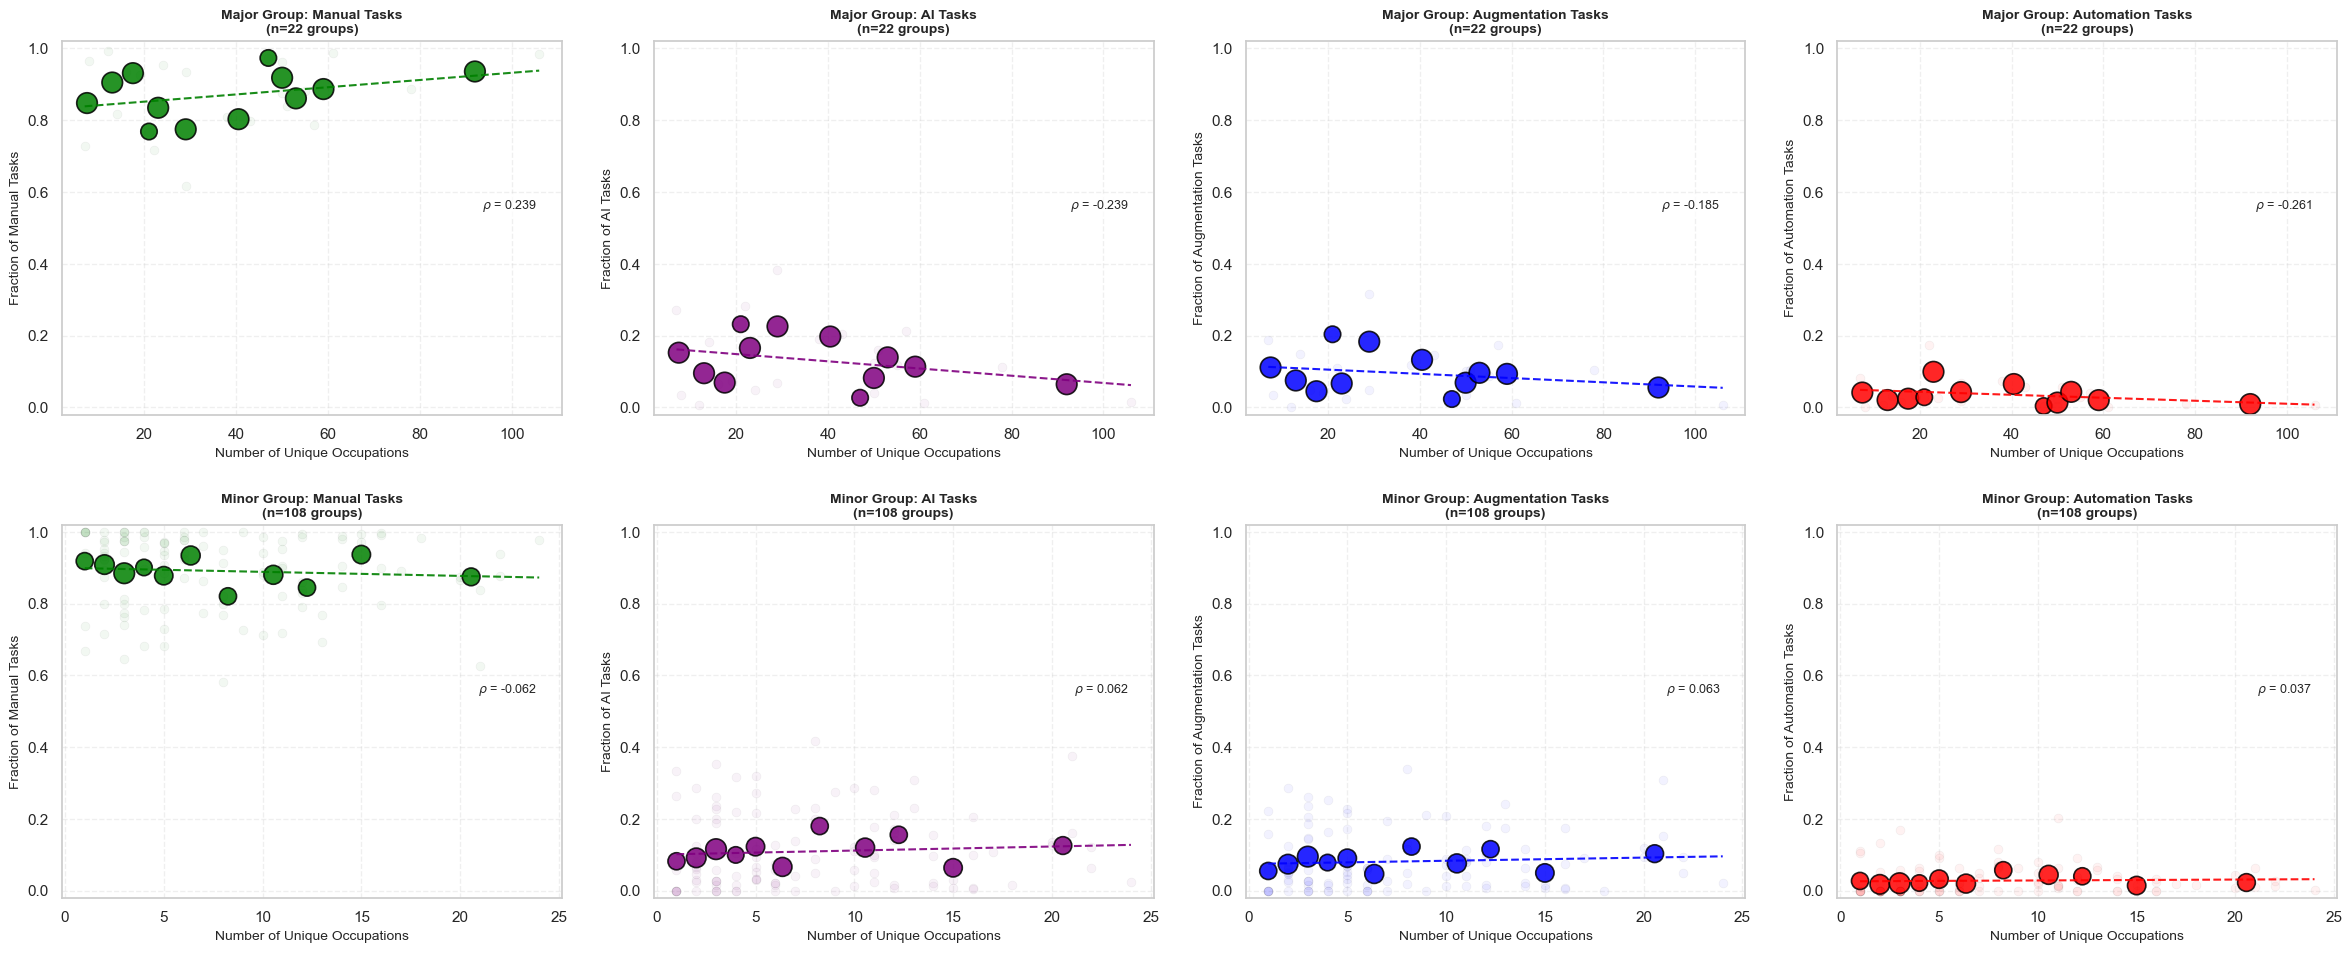

In [361]:
# 2x4 SOC-level bin scatter for num_occupations: rows = Major and Minor only
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

# Define colors and labels for each plot (insert AI between Manual and Augmentation)
plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'), 
    ('automation_fraction', 'Automation', 'red')
]

# Bins for num_occupations axis (x) - use quantile bins for proportional bin sizes
num_bins = 12

# Only use the first two SOC levels (major_group and minor_group)
levels_to_plot = soc_levels[:2]

# For each selected SOC level, compute number of unique occupations per group
for row, (col, level_name) in enumerate(levels_to_plot):
    level_data = all_analyses[row].copy()
    if len(level_data) == 0:
        continue

    # Compute number of unique occupations per group (group_code granularity)
    occ_counts = merged_data.groupby(col)['O*NET-SOC Code'].nunique()
    level_data = level_data.merge(occ_counts.rename('num_occupations'), left_on='group_code', right_index=True, how='left')

    x = level_data['num_occupations'].values
    x_min, x_max = x.min(), x.max()
    bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))

    for col_idx, (fraction_col, label, color) in enumerate(plot_configs):
        ax = axes[row, col_idx]
        y = level_data[fraction_col].values

        # Scatter plot (all points)
        ax.scatter(x, y, alpha=0.05, color=color, s=40, edgecolors='black', linewidth=0.5)

        # Add fitted regression line (global only)
        if len(x) > 1 and np.std(x) > 0:
            coeffs = np.polyfit(x, y, 1)
            fit_fn = np.poly1d(coeffs)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = fit_fn(x_fit)
            ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)

        # Bin the x axis and overlay bin means (no bin-fitted line)
        bin_indices = np.digitize(x, bin_edges, right=True) - 1
        bin_means_x = []
        bin_means_y = []
        bin_counts = []
        for b in range(len(bin_edges) - 1):
            in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
            if b == len(bin_edges) - 2:
                in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
            if np.any(in_bin):
                bin_means_x.append(x[in_bin].mean())
                bin_means_y.append(y[in_bin].mean())
                bin_counts.append(in_bin.sum())

        # Scale marker sizes by bin counts
        min_size = 60
        max_size = 220
        sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []

        if bin_means_x:
            ax.scatter(bin_means_x, bin_means_y, color=color, s=sizes, alpha=0.85, edgecolors='black', linewidth=1.2)

        # Customize each subplot
        ax.set_xlabel('Number of Unique Occupations', fontsize=10)
        ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=10)
        ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} groups)', fontsize=10, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(-0.02, 1.02)
        x_padding = max(1, (x_max - x_min) * 0.05)
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        correlation = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
        ax.text(0.95, 0.58, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout(pad=2.0)
plt.savefig(f'{output_plot_path}/SOChierarchy_numOccs_vs_taskTypes.png', dpi=300, bbox_inches='tight')
# plt.show()

Observations used in regression: 94

Fitting model: no_FE | formula: ai_fraction ~ num_occupations

Fitting model: major_group_FE | formula: ai_fraction ~ num_occupations + C(major_group)


,model,coef_num_occupations,coef_4sig,se,pval,nobs
0,no_FE,0.00,0.001486,0.00,0.52,94
1,major_group_FE,-0.00,-0.0005869,0.00,0.75,94



Model: no_FE
                            OLS Regression Results                            
Dep. Variable:            ai_fraction   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4148
Date:                Sat, 25 Oct 2025   Prob (F-statistic):              0.521
Time:                        19:47:47   Log-Likelihood:                 79.091
No. Observations:                  94   AIC:                            -154.2
Df Residuals:                      92   BIC:                            -149.1
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0976  

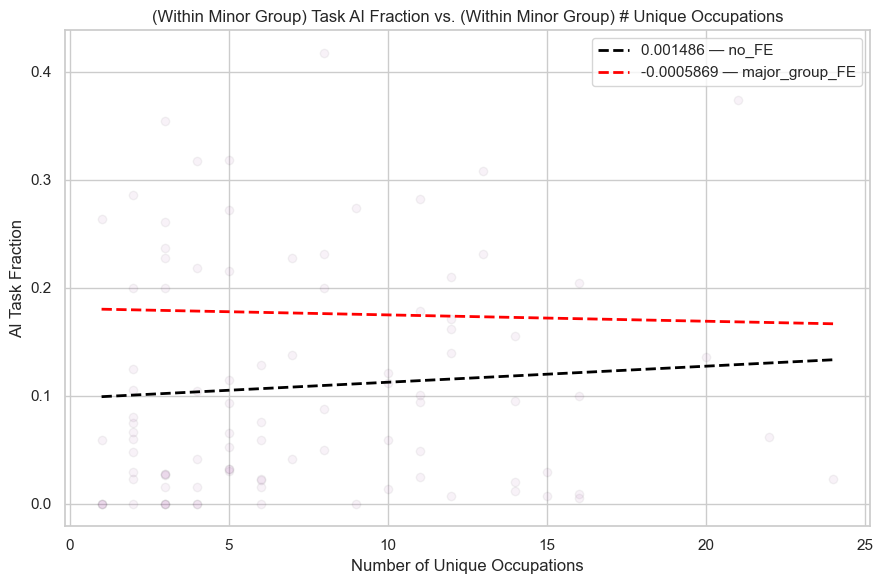

In [362]:
# Regression: AI task fraction on number of unique occupations (no FE, major_group FE)
import statsmodels.formula.api as smf
import seaborn as sns
sns.set(style='whitegrid')

# Prepare dataframe
df = minor_group_analysis.copy()
df['major_group'] = df['Minor_Group_Code'].astype(str).str[:2]
df = df.dropna(subset=['ai_fraction', 'num_occupations']).reset_index(drop=True)
print(f'Observations used in regression: {len(df):,}')

# Define FE options: None = no fixed effects, then major_group
fe_options = [None, 'major_group']
models = {}
results_summary = []

for fe in fe_options:
    if fe is None:
        formula = 'ai_fraction ~ num_occupations'
        label = 'no_FE'
    else:
        formula = f'ai_fraction ~ num_occupations + C({fe})'
        label = f'{fe}_FE'
    print(f'\nFitting model: {label} | formula: {formula}')
    model = smf.ols(formula, data=df).fit(cov_type='HC3')
    models[label] = model
    coef = model.params.get('num_occupations', np.nan)
    se = model.bse.get('num_occupations', np.nan)
    pval = model.pvalues.get('num_occupations', np.nan)
    # formatted coefficient with 4 significant digits (use 'nan' text for missing)
    formatted_coef = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    results_summary.append({'model': label, 'coef_num_occupations': coef, 'coef_4sig': formatted_coef, 'se': se, 'pval': pval, 'nobs': int(model.nobs)})

# Create and display a compact coefficient table for the num_occupations coefficient across models
coef_table = pd.DataFrame(results_summary)
display(coef_table)

# Print full summaries for each model
for label, model in models.items():
    print('\n' + '='*80)
    print(f'Model: {label}')
    print(model.summary())

# Compute quantile-binned means for overlay (will plot these with opacity=0.9)
num_bins = 8
x = df['num_occupations'].values
y = df['ai_fraction'].values
bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
bin_means_x = []
bin_means_y = []
bin_counts = []
for b in range(len(bin_edges) - 1):
    in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
    if b == len(bin_edges) - 2:
        in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
    if np.any(in_bin):
        bin_means_x.append(x[in_bin].mean())
        bin_means_y.append(y[in_bin].mean())
        bin_counts.append(in_bin.sum())
# sizes scaled by counts (guard against divide-by-zero)
if bin_counts:
    min_size = 80
    max_size = 300
    sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts]
else:
    sizes = []

# Plot fitted lines from each model on the same scatter for comparison and overlay binned scatters
fig, ax = plt.subplots(figsize=(9, 6))
# raw (faded) scatter of all observations
ax.scatter(df['num_occupations'], df['ai_fraction'], alpha=0.05, color='purple', edgecolors='k')
x_vals = np.linspace(df['num_occupations'].min(), df['num_occupations'].max(), 200)

# # overlay binned scatter with high opacity (0.9)
# if bin_means_x:
#     ax.scatter(bin_means_x, bin_means_y, color='orange', s=sizes, alpha=0.9, edgecolors='black', linewidths=1.2, label='Binned means (alpha=0.9)')

# colors for each model label
colors = {'no_FE': 'black', 'major_group_FE': 'red', 'minor_group_FE': 'blue'}
for label, model in models.items():
    coef = model.params.get('num_occupations', np.nan)
    formatted = f"{coef:.4g}" if (not pd.isna(coef)) else 'nan'
    legend_label = f"{formatted} — {label}"
    if 'num_occupations' in model.params:
        intercept = model.params.get('Intercept', 0)
        slope = model.params.get('num_occupations', 0)
        ax.plot(x_vals, intercept + slope * x_vals, color=colors.get(label, 'gray'), linestyle='--', linewidth=2, label=legend_label)
ax.set_xlabel('Number of Unique Occupations')
ax.set_ylabel('AI Task Fraction')
ax.set_title('(Within Minor Group) Task AI Fraction vs. (Within Minor Group) # Unique Occupations')
ax.legend()
plt.tight_layout()
plt.savefig(f'{output_plot_path}/withinMinorGroup_regression_aiTaskFraction_vs_numOccupations.png', dpi=300, bbox_inches='tight')
plt.show()

In [363]:
# Analysis: Distribution of AI-affected jobs within major and minor groups
# Label occupations as Manual or AI based on task fractions, then analyze group-level distributions

# Add SOC hierarchy levels to occupation analysis
occupation_analysis['major_group'] = occupation_analysis['O*NET-SOC Code'].str[:2]
occupation_analysis['minor_group'] = occupation_analysis['O*NET-SOC Code'].str[:5]

# Label each occupation as Manual or AI based on which fraction is greater
occupation_analysis['occupation_label'] = occupation_analysis.apply(
    lambda row: 'AI' if row['ai_fraction'] > row['manual_fraction'] else 'Manual', 
    axis=1
)

print("Occupation labeling completed:")
print(f"Total occupations: {len(occupation_analysis):,}")
print(f"Manual occupations: {(occupation_analysis['occupation_label'] == 'Manual').sum():,}")
print(f"AI occupations: {(occupation_analysis['occupation_label'] == 'AI').sum():,}")
print(f"Manual percentage: {(occupation_analysis['occupation_label'] == 'Manual').mean()*100:.1f}%")
print(f"AI percentage: {(occupation_analysis['occupation_label'] == 'AI').mean()*100:.1f}%")

# Analysis for both major and minor groups
group_levels = [
    ('major_group', 'Major Group'),
    ('minor_group', 'Minor Group')
]

for group_col, group_name in group_levels:
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR {group_name.upper()}")
    print(f"{'='*60}")
    
    # Calculate distribution of Manual vs AI occupations within each group
    group_analysis = []
    
    for group_code, group_data in occupation_analysis.groupby(group_col):
        total_occupations = len(group_data)
        manual_occupations = (group_data['occupation_label'] == 'Manual').sum()
        ai_occupations = (group_data['occupation_label'] == 'AI').sum()
        
        manual_fraction = manual_occupations / total_occupations
        ai_fraction = ai_occupations / total_occupations
        
        # Get average task fractions for this group
        avg_manual_task_fraction = group_data['manual_fraction'].mean()
        avg_ai_task_fraction = group_data['ai_fraction'].mean()
        
        group_analysis.append({
            'group_code': group_code,
            'total_occupations': total_occupations,
            'manual_occupations': manual_occupations,
            'ai_occupations': ai_occupations,
            'manual_occupation_fraction': manual_fraction,
            'ai_occupation_fraction': ai_fraction,
            'avg_manual_task_fraction': avg_manual_task_fraction,
            'avg_ai_task_fraction': avg_ai_task_fraction
        })
    
    # Create DataFrame and sort by AI occupation fraction (descending)
    group_df = pd.DataFrame(group_analysis)
    group_df = group_df.sort_values('ai_occupation_fraction', ascending=False)
    
    print(f"\nTop 10 {group_name}s by AI Occupation Fraction:")
    print("-" * 80)
    
    # Display top 10 rows with formatted output
    top_10 = group_df.head(10)
    for idx, row in top_10.iterrows():
        print(f"{row['group_code']}: {row['ai_occupations']}/{row['total_occupations']} ({row['ai_occupation_fraction']:.1%}) AI occupations")
        print(f"   Avg task fractions - Manual: {row['avg_manual_task_fraction']:.3f}, AI: {row['avg_ai_task_fraction']:.3f}")
        print()
    
    # Summary statistics
    print(f"Summary for {group_name}:")
    print(f"  Number of groups: {len(group_df)}")
    print(f"  Groups with >50% AI occupations: {(group_df['ai_occupation_fraction'] > 0.5).sum()}")
    print(f"  Groups with >75% AI occupations: {(group_df['ai_occupation_fraction'] > 0.75).sum()}")
    print(f"  Average AI occupation fraction across groups: {group_df['ai_occupation_fraction'].mean():.3f}")
    print(f"  Max AI occupation fraction: {group_df['ai_occupation_fraction'].max():.3f}")
    print(f"  Min AI occupation fraction: {group_df['ai_occupation_fraction'].min():.3f}")
    
    # Store results for potential further analysis
    if group_col == 'major_group':
        major_group_analysis = group_df.copy()
    else:
        minor_group_analysis = group_df.copy()

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE")
print(f"Results stored in 'major_group_analysis' and 'minor_group_analysis' DataFrames")

# 2x4 bin scatter highlight loop: highlight bins for each major group (x = num unique occupations per group)
RUN_OCCUPATION_HIGHLIGHT_LOOP = True  # Set to False to only run for one major group for testing
TEST_HIGHLIGHT_MG = '11'  # Example: Management Occupations
unique_major_groups = sorted(merged_data['major_group'].unique())
print(f"Will create up to {len(unique_major_groups)} separate 2x4 figures (save-only).")

# Map major group codes to readable names (extend as needed)
major_group_names = {
    '11': 'Management Occupations',
    '13': 'Business and Financial Operations',
    '15': 'Computer and Mathematical Occupations',
    '17': 'Architecture and Engineering',
    '19': 'Life, Physical, and Social Science',
    '21': 'Community and Social Service',
    '23': 'Legal Occupations',
    '25': 'Educational Instruction and Library',
    '27': 'Arts, Design, Entertainment, Sports, and Media',
    '29': 'Healthcare Practitioners and Technical',
    '31': 'Healthcare Support',
    '33': 'Protective Service',
    '35': 'Food Preparation and Serving Related',
    '37': 'Building and Grounds Cleaning and Maintenance',
    '39': 'Personal Care and Service',
    '41': 'Sales and Related',
    '43': 'Office and Administrative Support',
    '45': 'Farming, Fishing and Forestry',
    '47': 'Construction and Extraction',
    '49': 'Installation, Maintenance, and Repair',
    '51': 'Production',
    '53': 'Transportation and Material Moving'
}

plot_configs = [
    ('manual_fraction', 'Manual', 'green'),
    ('ai_fraction', 'AI', 'purple'),
    ('augmentation_fraction', 'Augmentation', 'blue'),
    ('automation_fraction', 'Automation', 'red')
]
num_bins = 12
group_levels = [('major_group', 'Major Group'), ('minor_group', 'Minor Group')]

if RUN_OCCUPATION_HIGHLIGHT_LOOP:
    iter_mgs = unique_major_groups
else:
    iter_mgs = [TEST_HIGHLIGHT_MG]

for highlight_mg in iter_mgs:
    mg_name = major_group_names.get(highlight_mg, f'Major Group {highlight_mg}')
    print(f"Preparing 2x4 figure for: MG {highlight_mg} - {mg_name}")

    fig, axes = plt.subplots(2, 4, figsize=(24, 10))

    for row, (group_col, level_name) in enumerate(group_levels):
        level_data = all_analyses[row].copy()
        if len(level_data) == 0:
            continue

        # Compute number of unique occupations per group
        occ_counts = merged_data.groupby(group_col)['O*NET-SOC Code'].nunique()
        level_data = level_data.merge(occ_counts.rename('num_occupations'), left_on='group_code', right_index=True, how='left')

        x = level_data['num_occupations'].values
        x_min, x_max = x.min(), x.max()
        bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))

        # Identify which groups belong to the highlighted major group
        # For major_group: group_code == highlight_mg
        # For minor_group: group_code[:2] == highlight_mg
        if group_col == 'major_group':
            highlight_mask = level_data['group_code'] == highlight_mg
        else:
            highlight_mask = level_data['group_code'].str[:2] == highlight_mg

        for col_idx, (fraction_col, label, color) in enumerate(plot_configs):
            ax = axes[row, col_idx]
            y = level_data[fraction_col].values

            # Plot all data points in muted gray (lower visibility to emphasize zeros)
            ax.scatter(x, y, alpha=0.05, color='lightgray', s=30, edgecolors='none')

            # Highlight the bins for the current major group
            if highlight_mask.sum() > 0:
                x_hl = x[highlight_mask]
                y_hl = y[highlight_mask]
                ax.scatter(x_hl, y_hl, alpha=0.95, color='yellow', s=60, edgecolors='red', linewidth=0.8)

            # Add fitted regression line for all data points
            if len(x) > 1 and np.std(x) > 0:
                coeffs = np.polyfit(x, y, 1)
                fit_fn = np.poly1d(coeffs)
                x_fit = np.linspace(x.min(), x.max(), 100)
                y_fit = fit_fn(x_fit)
                ax.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=1.5, alpha=0.9, zorder=2)

            # Add fitted regression line for highlighted bins (if any)
            if highlight_mask.sum() > 1:
                x_hl = x[highlight_mask]
                y_hl = y[highlight_mask]
                if np.std(x_hl) > 0:
                    coeffs_hl = np.polyfit(x_hl, y_hl, 1)
                    fit_fn_hl = np.poly1d(coeffs_hl)
                    x_fit_hl = np.linspace(x_hl.min(), x_hl.max(), 100)
                    y_fit_hl = fit_fn_hl(x_fit_hl)
                    ax.plot(x_fit_hl, y_fit_hl, color='orange', linestyle='-', linewidth=2.0, alpha=0.9, zorder=3)

            # Bin the x axis and overlay bin means (no bin-fitted line)
            bin_indices = np.digitize(x, bin_edges, right=True) - 1
            bin_means_x = []
            bin_means_y = []
            bin_counts = []
            for b in range(len(bin_edges) - 1):
                in_bin = (x >= bin_edges[b]) & (x < bin_edges[b + 1])
                if b == len(bin_edges) - 2:
                    in_bin = (x >= bin_edges[b]) & (x <= bin_edges[b + 1])
                if np.any(in_bin):
                    bin_means_x.append(x[in_bin].mean())
                    bin_means_y.append(y[in_bin].mean())
                    bin_counts.append(in_bin.sum())

            # Scale marker sizes by bin counts
            min_size = 60
            max_size = 220
            sizes = [min_size + (max_size - min_size) * (bc / max(bin_counts)) for bc in bin_counts] if bin_counts else []

            if bin_means_x:
                ax.scatter(bin_means_x, bin_means_y, color=color, s=sizes, alpha=0.9, edgecolors='black', linewidth=1.2)

            # Customize each subplot
            ax.set_xlabel('Number of Unique Occupations', fontsize=10)
            ax.set_ylabel(f'Fraction of {label} Tasks', fontsize=10)
            ax.set_title(f'{level_name}: {label} Tasks\n(n={len(level_data):,} groups)', fontsize=10, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_ylim(-0.02, 1.02)
            x_padding = max(1, (x_max - x_min) * 0.05)
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            correlation = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
            ax.text(0.95, 0.58, r'$\rho$' +f' = {correlation:.3f}', transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            highlighted_count = highlight_mask.sum()
            ax.text(0.95, 0.46, f'MG {highlight_mg}: {highlighted_count} bins', transform=ax.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    plt.suptitle(f'Number of Occupations SOC Hierarchy Analysis - {mg_name} (MG {highlight_mg} highlighted)', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(pad=2.0, rect=[0, 0, 1, 1])

    # Save each figure with major group identifier and do not display
    output_plot_folder = f'{output_plot_path}/numOccupations_MajorGroup_highlighted'
    os.makedirs(output_plot_folder, exist_ok=True)
    out_path = f'{output_plot_folder}/SOChierarchy_numOccupations_vs_taskTypeShares_MG_{highlight_mg}.png'
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

print(f"\nCompleted run. Generated occupation-level highlight figures saved to {output_plot_folder} (if RUN_OCCUPATION_HIGHLIGHT_LOOP=True then all groups were generated).")

Occupation labeling completed:
Total occupations: 837
Manual occupations: 815
AI occupations: 22
Manual percentage: 97.4%
AI percentage: 2.6%

ANALYSIS FOR MAJOR GROUP

Top 10 Major Groups by AI Occupation Fraction:
--------------------------------------------------------------------------------
15: 9/29 (31.0%) AI occupations
   Avg task fractions - Manual: 0.587, AI: 0.413

23: 1/7 (14.3%) AI occupations
   Avg task fractions - Manual: 0.720, AI: 0.280

27: 3/38 (7.9%) AI occupations
   Avg task fractions - Manual: 0.792, AI: 0.208

19: 4/57 (7.0%) AI occupations
   Avg task fractions - Manual: 0.774, AI: 0.226

25: 1/22 (4.5%) AI occupations
   Avg task fractions - Manual: 0.719, AI: 0.281

13: 1/43 (2.3%) AI occupations
   Avg task fractions - Manual: 0.804, AI: 0.196

53: 1/47 (2.1%) AI occupations
   Avg task fractions - Manual: 0.963, AI: 0.037

43: 1/51 (2.0%) AI occupations
   Avg task fractions - Manual: 0.852, AI: 0.148

17: 1/55 (1.8%) AI occupations
   Avg task fractions -

## Alternative Measure for Number of Occupations Analysis: Fraction of AI-able Occupations (instead of AI-able Tasks)

#### AI-able Occupation --> Occupation whose majority of tasks are done via AI

Occupation labeling completed:
Total occupations: 837
Manual occupations: 815
AI occupations: 22
Manual percentage: 97.4%
AI percentage: 2.6%

ANALYSIS FOR MAJOR GROUP


,group_code,total_occupations,manual_occupations,ai_occupations,manual_occupation_fraction,ai_occupation_fraction,avg_manual_task_fraction,avg_ai_task_fraction
2,15,29,20,9,0.69,0.31,0.59,0.41
6,23,7,6,1,0.86,0.14,0.72,0.28
8,27,38,35,3,0.92,0.08,0.79,0.21
4,19,57,53,4,0.93,0.07,0.77,0.23
7,25,22,21,1,0.95,0.05,0.72,0.28


15: 9/29 (31.0%) AI occupations
   Avg task fractions - Manual: 0.587, AI: 0.413

23: 1/7 (14.3%) AI occupations
   Avg task fractions - Manual: 0.720, AI: 0.280

27: 3/38 (7.9%) AI occupations
   Avg task fractions - Manual: 0.792, AI: 0.208

19: 4/57 (7.0%) AI occupations
   Avg task fractions - Manual: 0.774, AI: 0.226

25: 1/22 (4.5%) AI occupations
   Avg task fractions - Manual: 0.719, AI: 0.281


ANALYSIS FOR MINOR GROUP


,group_code,total_occupations,manual_occupations,ai_occupations,manual_occupation_fraction,ai_occupation_fraction,avg_manual_task_fraction,avg_ai_task_fraction
10,15-20,8,5,3,0.62,0.38,0.55,0.45
9,15-12,21,15,6,0.71,0.29,0.60,0.40
22,23-10,5,4,1,0.80,0.20,0.66,0.34
26,25-40,5,4,1,0.80,0.20,0.70,0.30
17,19-30,13,11,2,0.85,0.15,0.67,0.33


15-20: 3/8 (37.5%) AI occupations
   Avg task fractions - Manual: 0.553, AI: 0.447

15-12: 6/21 (28.6%) AI occupations
   Avg task fractions - Manual: 0.600, AI: 0.400

23-10: 1/5 (20.0%) AI occupations
   Avg task fractions - Manual: 0.658, AI: 0.342

25-40: 1/5 (20.0%) AI occupations
   Avg task fractions - Manual: 0.703, AI: 0.297

19-30: 2/13 (15.4%) AI occupations
   Avg task fractions - Manual: 0.673, AI: 0.327



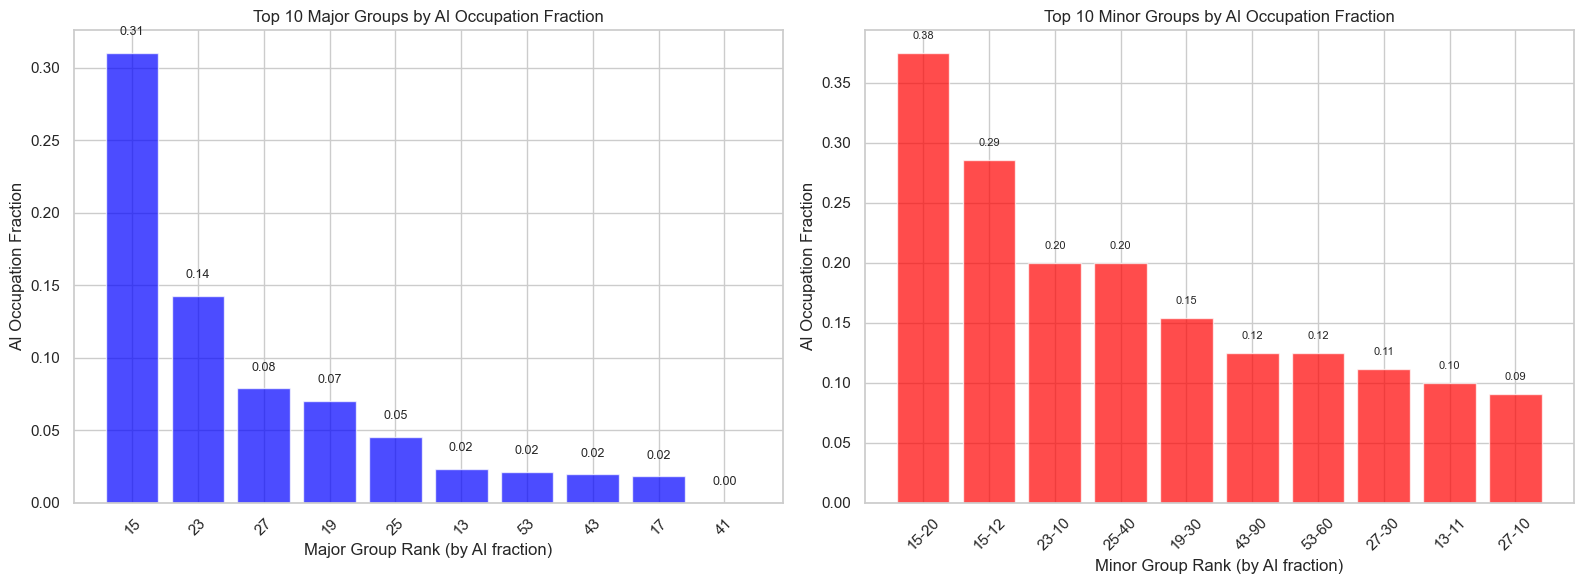


SAMPLE AI-DOMINATED OCCUPATIONS:
Top 15 AI-dominated occupations:
Bioinformatics Technicians                         (AI: 0.818, Manual: 0.182)
Data Warehousing Specialists                       (AI: 0.722, Manual: 0.278)
Historians                                         (AI: 0.706, Manual: 0.294)
Computer Programmers                               (AI: 0.692, Manual: 0.308)
Traffic Technicians                                (AI: 0.667, Manual: 0.333)
Writers and Authors                                (AI: 0.667, Manual: 0.333)
Arbitrators, Mediators, and Conciliators           (AI: 0.636, Manual: 0.364)
Information Security Analysts                      (AI: 0.636, Manual: 0.364)
Fine Artists, Including Painters, Sculptors, and I (AI: 0.625, Manual: 0.375)
Database Architects                                (AI: 0.625, Manual: 0.375)
Business Intelligence Analysts                     (AI: 0.625, Manual: 0.375)
Microsystems Engineers                             (AI: 0.625, Manual: 0.37

In [ ]:
# Analysis: Distribution of AI-affected jobs within major and minor groups
# Label occupations as Manual or AI based on task fractions, then analyze group-level distributions

# Add SOC hierarchy levels to occupation analysis
occupation_analysis['major_group'] = occupation_analysis['O*NET-SOC Code'].str[:2]
occupation_analysis['minor_group'] = occupation_analysis['O*NET-SOC Code'].str[:5]

# Label each occupation as Manual or AI based on which fraction is greater
occupation_analysis['occupation_label'] = occupation_analysis.apply(
    lambda row: 'AI' if row['ai_fraction'] > row['manual_fraction'] else 'Manual', 
    axis=1
)

print("Occupation labeling completed:")
print(f"Total occupations: {len(occupation_analysis):,}")
print(f"Manual occupations: {(occupation_analysis['occupation_label'] == 'Manual').sum():,}")
print(f"AI occupations: {(occupation_analysis['occupation_label'] == 'AI').sum():,}")
print(f"Manual percentage: {(occupation_analysis['occupation_label'] == 'Manual').mean()*100:.1f}%")
print(f"AI percentage: {(occupation_analysis['occupation_label'] == 'AI').mean()*100:.1f}%")

# Analysis for both major and minor groups
group_levels = [
    ('major_group', 'Major Group', 'majorGroup'),
    ('minor_group', 'Minor Group', 'minorGroup')
]

for group_col, group_name, group_output_code in group_levels:
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR {group_name.upper()}")
    print(f"{'='*60}")
    
    # Calculate distribution of Manual vs AI occupations within each group
    group_analysis = []
    
    for group_code, group_data in occupation_analysis.groupby(group_col):
        total_occupations = len(group_data)
        manual_occupations = (group_data['occupation_label'] == 'Manual').sum()
        ai_occupations = (group_data['occupation_label'] == 'AI').sum()
        
        manual_fraction = manual_occupations / total_occupations
        ai_fraction = ai_occupations / total_occupations
        
        # Get average task fractions for this group
        avg_manual_task_fraction = group_data['manual_fraction'].mean()
        avg_ai_task_fraction = group_data['ai_fraction'].mean()
        
        group_analysis.append({
            'group_code': group_code,
            'total_occupations': total_occupations,
            'manual_occupations': manual_occupations,
            'ai_occupations': ai_occupations,
            'manual_occupation_fraction': manual_fraction,
            'ai_occupation_fraction': ai_fraction,
            'avg_manual_task_fraction': avg_manual_task_fraction,
            'avg_ai_task_fraction': avg_ai_task_fraction
        })
    
    # Create DataFrame and sort by AI occupation fraction (descending)
    group_df = pd.DataFrame(group_analysis)
    group_df = group_df.sort_values('ai_occupation_fraction', ascending=False)

    display(group_df.head(5))
    
    # Display top 5 rows with formatted output
    top_5 = group_df.head(5)
    for idx, row in top_5.iterrows():
        print(f"{row['group_code']}: {row['ai_occupations']}/{row['total_occupations']} ({row['ai_occupation_fraction']:.1%}) AI occupations")
        print(f"   Avg task fractions - Manual: {row['avg_manual_task_fraction']:.3f}, AI: {row['avg_ai_task_fraction']:.3f}")
        print()
    
    # Save results
    group_df.to_csv(f'{output_data_path}/anthropic_{group_output_code}Level_occupationExposure_dataset.csv', index=False)

    # Store results for potential further analysis
    if group_col == 'major_group':
        major_group_analysis = group_df.copy()
    else:
        minor_group_analysis = group_df.copy()



# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Major Groups
major_plot_data = major_group_analysis.head(10)
bars1 = ax1.bar(range(len(major_plot_data)), major_plot_data['ai_occupation_fraction'], 
                color='blue', alpha=0.7)
ax1.set_xlabel('Major Group Rank (by AI fraction)')
ax1.set_ylabel('AI Occupation Fraction')
ax1.set_title('Top 10 Major Groups by AI Occupation Fraction')
ax1.set_xticks(range(len(major_plot_data)))
ax1.set_xticklabels(major_plot_data['group_code'], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Minor Groups  
minor_plot_data = minor_group_analysis.head(10)
bars2 = ax2.bar(range(len(minor_plot_data)), minor_plot_data['ai_occupation_fraction'],
                color='red', alpha=0.7)
ax2.set_xlabel('Minor Group Rank (by AI fraction)')
ax2.set_ylabel('AI Occupation Fraction')
ax2.set_title('Top 10 Minor Groups by AI Occupation Fraction')
ax2.set_xticks(range(len(minor_plot_data)))
ax2.set_xticklabels(minor_plot_data['group_code'], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/ai_occupation_fractions_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

# Show some interesting AI-dominated occupations
print("\n" + "="*80)
print("SAMPLE AI-DOMINATED OCCUPATIONS:")
print("="*80)

ai_occupations = occupation_analysis[occupation_analysis['occupation_label'] == 'AI']
ai_occupations_sorted = ai_occupations.sort_values('ai_fraction', ascending=False)

print("Top 15 AI-dominated occupations:")
for idx, row in ai_occupations_sorted.head(15).iterrows():
    print(f"{row['Occupation Title'][:50]:<50} (AI: {row['ai_fraction']:.3f}, Manual: {row['manual_fraction']:.3f})")

print(f"\nTotal AI-dominated occupations: {len(ai_occupations):,} out of {len(occupation_analysis):,} ({len(ai_occupations)/len(occupation_analysis)*100:.1f}%)")

### Plot fraction of AI occupations against average number of AI tasks within occupation in industry groups (major+minor)

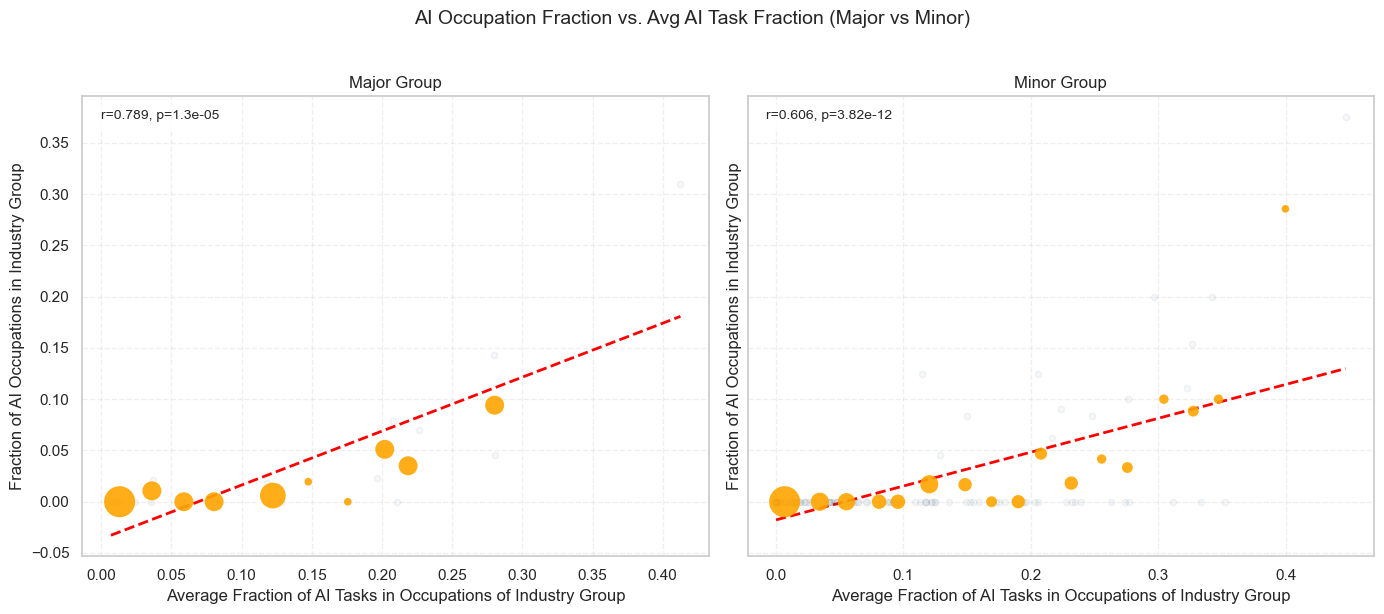

Saved combined figure to: ../writeup/plots/anthropic_AI_index/AIoccupationFraction_vs_avgAItaskFraction_industryGroup.png


In [ ]:
# Plot: AI occupation fraction vs average AI task fraction (major & minor groups) — combined 1x2 with binscatter
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- sanity checks ---
if 'major_group_analysis' not in locals() or 'minor_group_analysis' not in locals():
    raise RuntimeError("major_group_analysis or minor_group_analysis not found. Run the earlier analysis cells first.")

# --- config ---
required_cols = {'ai_occupation_fraction', 'avg_ai_task_fraction'}
n_bins = 20                          # number of bins along x
bin_min_size, bin_max_size = 30, 500 # marker size range for bins
scatter_alpha = 0.05                 # original scatter opacity
bin_alpha = 0.90                     # bin-scatters opacity
bin_color = 'orange'

def add_regression(ax, x, y):
    if len(x) > 1 and np.std(x) > 0 and np.std(y) > 0:
        slope, intercept, r, p, se = linregress(x, y)
        xx = np.linspace(x.min(), x.max(), 200)
        yy = intercept + slope * xx
        ax.plot(xx, yy, color='red', linestyle='--', linewidth=2, zorder=2)
        ax.text(0.03, 0.97, f'r={r:.3f}, p={p:.3g}', transform=ax.transAxes,
                fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.7))

def add_binscatter(ax, data_x, data_y):
    # bin along x
    bins = np.linspace(data_x.min(), data_x.max(), n_bins + 1)
    idx = np.digitize(data_x, bins) - 1
    # keep valid bins
    mask = (idx >= 0) & (idx < n_bins)
    idx = idx[mask]
    x = data_x[mask]
    y = data_y[mask]

    # aggregate: mean x, mean y, and count per bin
    dfb = pd.DataFrame({'bin': idx, 'x': x, 'y': y}).groupby('bin').agg(
        x_mean=('x', 'mean'),
        y_mean=('y', 'mean'),
        n=('y', 'size')
    ).reset_index(drop=True)

    if dfb.empty:
        return

    # size scale by count
    n_min, n_max = dfb['n'].min(), dfb['n'].max()
    if n_max == n_min:
        sizes = np.full(len(dfb), (bin_min_size + bin_max_size) / 2.0)
    else:
        sizes = bin_min_size + (dfb['n'] - n_min) * (bin_max_size - bin_min_size) / (n_max - n_min)

    ax.scatter(dfb['x_mean'], dfb['y_mean'],
               s=sizes, c=bin_color, alpha=bin_alpha, edgecolors='none', zorder=3)

def plot_panel(ax, df, title):
    # column check
    if not required_cols.issubset(df.columns):
        raise RuntimeError(f"DataFrame for {title} missing required columns: {required_cols}")

    d = df.dropna(subset=['ai_occupation_fraction', 'avg_ai_task_fraction']).copy()
    x = d['avg_ai_task_fraction'].to_numpy()
    y = d['ai_occupation_fraction'].to_numpy()

    # original points (very faint)
    ax.scatter(x, y, alpha=scatter_alpha, edgecolors='k', color='steelblue', s=20, zorder=3)

    # regression
    add_regression(ax, x, y)

    # binscatter (orange, sized by counts)
    add_binscatter(ax, x, y)

    ax.set_title(title)
    ax.set_xlabel('Average Fraction of AI Tasks in Occupations of Industry Group')
    ax.set_ylabel('Fraction of AI Occupations in Industry Group')
    ax.grid(True, linestyle='--', alpha=0.3)

# --- build 1x2 figure ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_panel(axes[0], major_group_analysis, 'Major Group')
plot_panel(axes[1], minor_group_analysis, 'Minor Group')
fig.suptitle('AI Occupation Fraction vs. Avg AI Task Fraction (Major vs Minor)', y=1.02, fontsize=14)

plt.tight_layout()

# Save
plt.savefig(f'{output_plot_path}/AIoccupationFraction_vs_avgAItaskFraction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved combined figure to: {output_plot_path}/AIoccupationFraction_vs_avgAItaskFraction_industryGroup.png')


--- Regression Results ---

(1) Major Groups Regression:
                               OLS Regression Results                              
Dep. Variable:     ai_occupation_fraction   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                 -0.025
Method:                     Least Squares   F-statistic:                    0.4964
Date:                    Sat, 25 Oct 2025   Prob (F-statistic):              0.489
Time:                            20:22:54   Log-Likelihood:                 27.595
No. Observations:                      22   AIC:                            -51.19
Df Residuals:                          20   BIC:                            -49.01
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

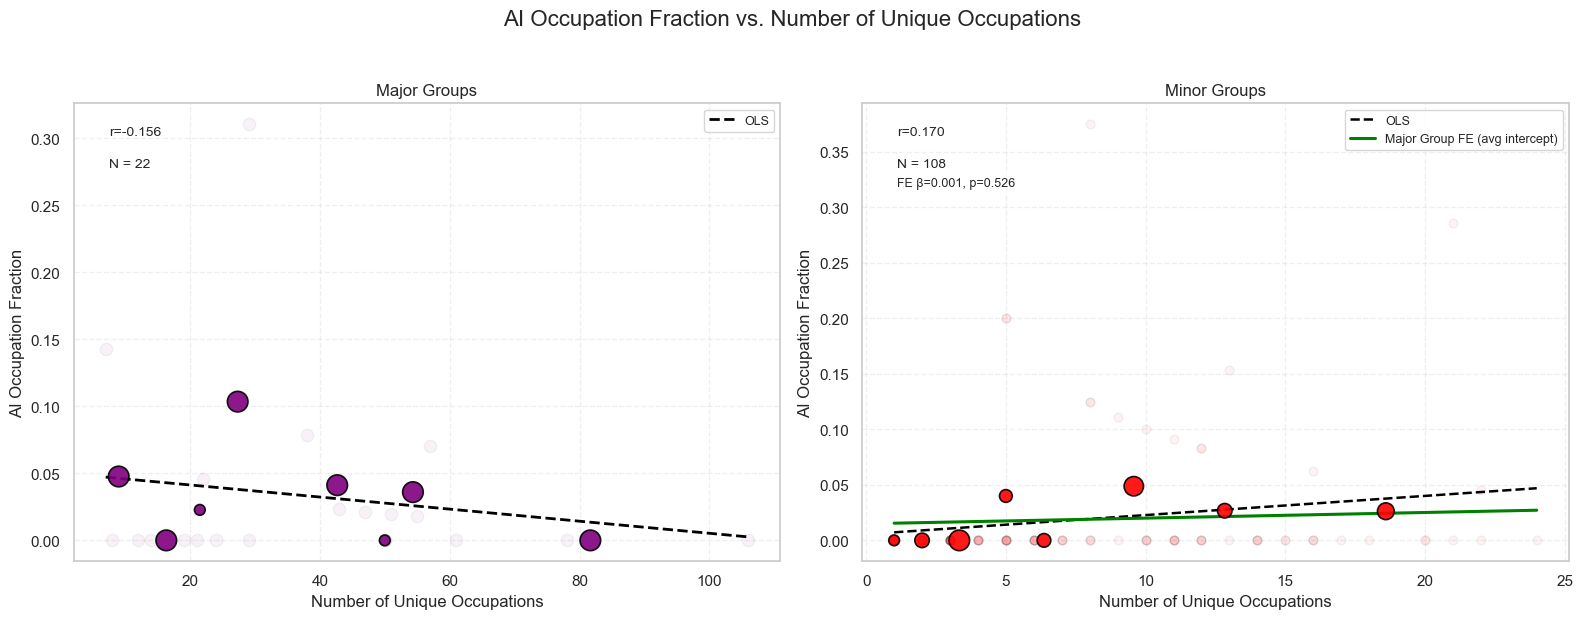

Saved scatter plots (OLS + bins; FE line on minor) to: /Users/peymanshahidi/MIT Dropbox/Peyman Shahidi/GitHub/rubin/writeup/plots/anthropic_AI_index/AIoccupationFraction_vs_numOccupations_with_FE.png


In [389]:
# === Scatter + Regressions (incl. FE line on minor subplot) ===
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Sanity checks
if 'major_group_analysis' not in locals() or 'minor_group_analysis' not in locals():
    raise RuntimeError("major_group_analysis or minor_group_analysis not found. Run the previous analysis cells first.")
if 'occupation_analysis' not in locals():
    raise RuntimeError("occupation_analysis not found. Run the earlier cells that build it.")

# Merge counts of unique occupations into group analyses
occ_counts_major = occupation_analysis.groupby('major_group')['O*NET-SOC Code'].nunique().rename('num_occupations')
occ_counts_minor = occupation_analysis.groupby('minor_group')['O*NET-SOC Code'].nunique().rename('num_occupations')

major_group_plot = major_group_analysis.merge(occ_counts_major, left_on='group_code', right_index=True, how='left')
minor_group_plot = minor_group_analysis.merge(occ_counts_minor, left_on='group_code', right_index=True, how='left')

# Ensure FE key: major_group code in minor data (first two chars of group_code)
if 'major_group' not in minor_group_plot.columns:
    minor_group_plot['major_group'] = minor_group_plot['group_code'].astype(str).str[:2]

print("\n--- Regression Results ---")

# (1) Major groups: AI Occupation Fraction ~ Number of Unique Occupations
reg1 = smf.ols('ai_occupation_fraction ~ num_occupations', data=major_group_plot).fit()
print("\n(1) Major Groups Regression:\n", reg1.summary())

# (2) Minor groups: AI Occupation Fraction ~ Number of Unique Occupations
reg2 = smf.ols('ai_occupation_fraction ~ num_occupations', data=minor_group_plot).fit()
print("\n(2) Minor Groups Regression:\n", reg2.summary())

# (3) Minor groups with major group fixed effects
reg3 = smf.ols('ai_occupation_fraction ~ num_occupations + C(major_group)', data=minor_group_plot).fit()
print("\n(3) Minor Groups Regression with Major Group Fixed Effects:\n", reg3.summary())

# Ensure output dir
os.makedirs(output_plot_path, exist_ok=True)

# ---- binscatter helper (quantile bins) ----
def plot_binned_means(ax, x, y, num_bins=8, min_size=60, max_size=220, color='black'):
    x = np.asarray(x); y = np.asarray(y)
    if len(x) == 0 or len(y) == 0 or np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return
    # quantile-based bin edges (unique to avoid empty bins due to ties)
    bin_edges = np.unique(np.quantile(x, np.linspace(0, 1, num_bins + 1)))
    if len(bin_edges) < 2:
        return
    x_means, y_means, counts = [], [], []
    for b in range(len(bin_edges) - 1):
        left, right = bin_edges[b], bin_edges[b + 1]
        in_bin = (x >= left) & (x < right) if b < len(bin_edges) - 2 else (x >= left) & (x <= right)
        if np.any(in_bin):
            x_means.append(np.mean(x[in_bin]))
            y_means.append(np.mean(y[in_bin]))
            counts.append(int(np.sum(in_bin)))
    if not x_means:
        return
    n_min, n_max = min(counts), max(counts)
    if n_max == n_min:
        sizes = np.full(len(counts), (min_size + max_size) / 2)
    else:
        sizes = min_size + (np.array(counts) - n_min) * (max_size - min_size) / (n_max - n_min)
    ax.scatter(x_means, y_means, color=color, s=sizes, alpha=0.9, edgecolors='black', linewidth=1.2, zorder=3)

# ---- plotting ----
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('AI Occupation Fraction vs. Number of Unique Occupations', fontsize=16, y=1.03)

# --- Major subplot ---
x_major = major_group_plot['num_occupations'].values
y_major = major_group_plot['ai_occupation_fraction'].values
ax[0].scatter(x_major, y_major, s=80, alpha=0.05, color='purple', edgecolor='k', zorder=1)

if len(x_major) > 1 and np.std(x_major) > 0 and np.std(y_major) > 0:
    slope_m, intercept_m, r_m, p_m, _ = linregress(x_major, y_major)
    x_fit_m = np.linspace(np.nanmin(x_major), np.nanmax(x_major), 200)
    y_fit_m = intercept_m + slope_m * x_fit_m
    ax[0].plot(x_fit_m, y_fit_m, color='black', linestyle='--', linewidth=2, label='OLS', zorder=2)
    ax[0].text(0.05, 0.95, f'r={r_m:.3f}', transform=ax[0].transAxes, fontsize=10, va='top')

plot_binned_means(ax[0], x_major, y_major, num_bins=8, color='purple')
ax[0].text(0.05, 0.88, f'N = {len(x_major)}', transform=ax[0].transAxes, fontsize=10, va='top',
           bbox=dict(facecolor='white', alpha=0.6))
ax[0].set_xlabel('Number of Unique Occupations')
ax[0].set_ylabel('AI Occupation Fraction')
ax[0].set_title('Major Groups')
ax[0].grid(True, linestyle='--', alpha=0.3)
ax[0].legend(frameon=True, fontsize=9)

# --- Minor subplot ---
x_minor = minor_group_plot['num_occupations'].values
y_minor = minor_group_plot['ai_occupation_fraction'].values
ax[1].scatter(x_minor, y_minor, s=40, alpha=0.05, color='red', edgecolor='k', zorder=1)

# OLS line for minor
if len(x_minor) > 1 and np.std(x_minor) > 0 and np.std(y_minor) > 0:
    slope_n, intercept_n, r_n, p_n, _ = linregress(x_minor, y_minor)
    x_fit_n = np.linspace(np.nanmin(x_minor), np.nanmax(x_minor), 200)
    y_fit_n = intercept_n + slope_n * x_fit_n
    ax[1].plot(x_fit_n, y_fit_n, color='black', linestyle='--', linewidth=1.8, label='OLS', zorder=2)
    ax[1].text(0.05, 0.95, f'r={r_n:.3f}', transform=ax[1].transAxes, fontsize=10, va='top')

# FE line (avg intercept across major-group FEs; slope = FE slope)
_minor = minor_group_plot.dropna(subset=['num_occupations','ai_occupation_fraction','major_group']).copy()
weights = _minor['major_group'].value_counts(normalize=True).to_dict()

beta_fe = reg3.params['num_occupations']
alpha_fe_base = reg3.params['Intercept']
avg_fe_shift = 0.0
for mg, wt in weights.items():
    key = f'C(major_group)[T.{mg}]'
    avg_fe_shift += wt * reg3.params.get(key, 0.0)

alpha_fe = alpha_fe_base + avg_fe_shift
xg = np.linspace(np.nanmin(x_minor), np.nanmax(x_minor), 200)
yg = alpha_fe + beta_fe * xg
ax[1].plot(xg, yg, color='green', linewidth=2.2, label='Major Group FE (avg intercept)', zorder=3)

plot_binned_means(ax[1], x_minor, y_minor, num_bins=8, color='red')
ax[1].text(0.05, 0.82, f'FE β={beta_fe:.3f}, p={reg3.pvalues["num_occupations"]:.3g}',
           transform=ax[1].transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
ax[1].text(0.05, 0.88, f'N = {len(x_minor)}', transform=ax[1].transAxes, fontsize=10, va='top',
           bbox=dict(facecolor='white', alpha=0.6))
ax[1].set_xlabel('Number of Unique Occupations')
ax[1].set_ylabel('AI Occupation Fraction')
ax[1].set_title('Minor Groups')
ax[1].grid(True, linestyle='--', alpha=0.3)
ax[1].legend(frameon=True, fontsize=9)

plt.tight_layout()
outfile = os.path.join(output_plot_path, 'AIoccupationFraction_vs_numOccupations_with_FE.png')
plt.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

print('Saved scatter plots (OLS + bins; FE line on minor) to:', os.path.abspath(outfile))

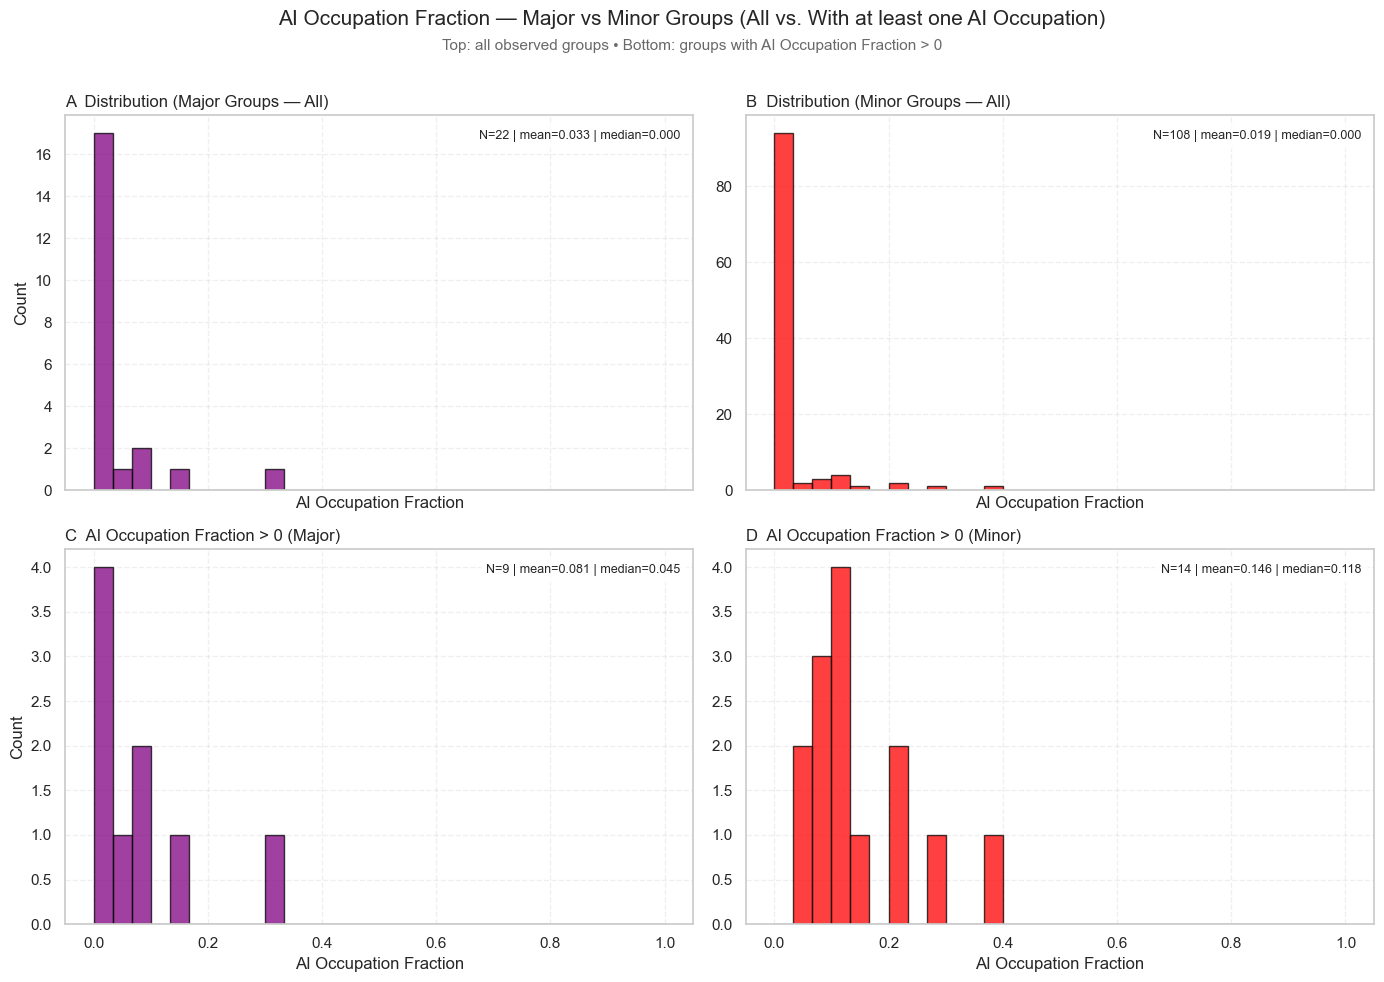

Saved 2x2 histogram figure to /Users/peymanshahidi/MIT Dropbox/Peyman Shahidi/GitHub/rubin/writeup/plots/anthropic_AI_index/hist_AIoccupationFraction.png


In [ ]:
# === AI Occupation Fraction Histogram (All vs >0; Major vs Minor) ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# --- sanity & prep ---
if 'major_group_analysis' not in locals() or 'minor_group_analysis' not in locals():
    raise RuntimeError('major_group_analysis or minor_group_analysis not found. Run the previous analysis cells first.')

# Recreate major/minor plots with num_occupations if missing; histograms only need ai_occupation_fraction
if 'num_occupations' not in major_group_analysis.columns:
    occ_counts_major = occupation_analysis.groupby('major_group')['O*NET-SOC Code'].nunique().rename('num_occupations')
    major_group_plot = major_group_analysis.merge(occ_counts_major, left_on='group_code', right_index=True, how='left')
else:
    major_group_plot = major_group_analysis.copy()

if 'num_occupations' not in minor_group_analysis.columns:
    occ_counts_minor = occupation_analysis.groupby('minor_group')['O*NET-SOC Code'].nunique().rename('num_occupations')
    minor_group_plot = minor_group_analysis.merge(occ_counts_minor, left_on='group_code', right_index=True, how='left')
else:
    minor_group_plot = minor_group_analysis.copy()

# --- data vectors ---
data_major_all = major_group_plot['ai_occupation_fraction'].dropna().to_numpy()
data_minor_all = minor_group_plot['ai_occupation_fraction'].dropna().to_numpy()
data_major_pos = major_group_plot.loc[major_group_plot['ai_occupation_fraction'] > 0, 'ai_occupation_fraction'].dropna().to_numpy()
data_minor_pos = minor_group_plot.loc[minor_group_plot['ai_occupation_fraction'] > 0, 'ai_occupation_fraction'].dropna().to_numpy()

# Common bins across all panels for comparability
all_vals = np.concatenate([data_major_all, data_minor_all])
bin_right = max(1.0, np.nanmax(all_vals))  # fractions are usually in [0,1], but guard anyway
bins = np.linspace(0, bin_right, 31)       # 30 bins

# --- helper to draw one panel ---
def draw_hist(ax, data, color, title, panel_tag, y_label=True):
    ax.hist(data, bins=bins, color=color, alpha=0.75, edgecolor='black')
    ax.set_title(f"{panel_tag}  {title}", loc='left', fontsize=12, pad=6)
    ax.set_xlabel('AI Occupation Fraction')
    if y_label:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel('')
    ax.grid(True, linestyle='--', alpha=0.3)
    # annotate N, mean, median
    if len(data) > 0:
        txt = f"N={len(data)} | mean={np.mean(data):.3f} | median={np.median(data):.3f}"
    else:
        txt = f"N=0"
    ax.text(0.98, 0.96, txt, transform=ax.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

# --- build 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Row 1: all groups
draw_hist(axes[0, 0], data_major_all, color='purple',
          title='Distribution (Major Groups — All)', panel_tag='A', y_label=True)
draw_hist(axes[0, 1], data_minor_all, color='red',
          title='Distribution (Minor Groups — All)', panel_tag='B', y_label=False)

# Row 2: positive-only
draw_hist(axes[1, 0], data_major_pos, color='purple',
          title='AI Occupation Fraction > 0 (Major)', panel_tag='C', y_label=True)
draw_hist(axes[1, 1], data_minor_pos, color='red',
          title='AI Occupation Fraction > 0 (Minor)', panel_tag='D', y_label=False)

# Figure-level title + subtitle
fig.suptitle('AI Occupation Fraction — Major vs Minor Groups (All vs. With at least one AI Occupation)', fontsize=15, y=0.98)
fig.text(0.5, 0.94, 'Top: all observed groups • Bottom: groups with AI Occupation Fraction > 0',
         ha='center', fontsize=11, color='dimgray')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save & show
out_2x2 = os.path.join(output_plot_path, 'AIoccupationFraction_hist.png')
os.makedirs(output_plot_path, exist_ok=True)
plt.savefig(out_2x2, dpi=300, bbox_inches='tight')
plt.show()

print('Saved 2x2 histogram figure to', os.path.abspath(out_2x2))
